# Malaria addInputEIR calibration

### A history matching approach to calibrating an empirical model of malaria infection and immunity

### In this version, we will be utilizing the full immune parameter space, sampling also which immune forces should be included in the calculation of the immune modifier (ie configurable params starting with "Immune_Modifier_Include*"

### For iter0 we will cut down parameter space by using the distribution of malaria prevalence by season, age and density bins from a moderate high transmission setting in Sugungum, Garki, Nigeria

# Import block

In [1]:
from IPython.extensions import autoreload
%load_ext autoreload
%autoreload 2
import os, glob, re, sys, json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
import itertools
from calibtool.analyzers.Helpers import \
    convert_to_counts, age_from_birth_cohort, season_from_time, aggregate_on_index

from wand.image import Image as WImage
from history_matching import HistoryMatching, HistoryMatchingCut, quick_read, Basis

import pycuda
from IPython.display import IFrame, display

from pyDOE import lhs
from history_matching import HistoryMatching, HistoryMatchingCut, quick_read, Basis
sns.set(font_scale=2)
sns.set_style("white")

C:\conda\envs\history_matching\lib\site-packages\skcuda\cublas.py:284: UserWarning: creating CUBLAS context to get version number
  warnings.warn('creating CUBLAS context to get version number')


In [2]:
def fix_glob(pth):
    return re.sub('([\[\]])','[\\1]', pth)

# Configure parameters and data for history matching

In [3]:
site = 'Sugungum'
season_cut = 'W2'
age_bin_cut = 8
density_bin_cut = 500

cut_name = f'{density_bin_cut}_{age_bin_cut}_{season_cut}_{site}'

# iteration = int(re.search(r'iter(\d+)', os.getcwd())) # Index of the current iteration
iteration = 0 
#list of exp_ids/folders that correspond to exp_ids from which our emulation will draw
exp_ids = ['b2d07e24-e360-ea11-a2c5-c4346bcb1550'] # TODO: only uses first for now, should loop
basedir = 'C:\git\Malaria-Uganda-PRISM'
datafile = os.path.join('..','reference data', 'Garki_df.csv')

In [4]:
# The implausibility threshold determines how willing we are to retain regions
# of parameter space that are inconsistent with the underlying data. A higher
# threshold is more risk averse in that potentially good regions are less likely
# to be rejected, however it will take more iterations/simulations to achieve results.
implausibility_threshold = 3
training_fraction = 0.75 # Fraction of simulations to use as training
discrepancy_std = 0.0 # Accounts for uncertainty w.r.t model structure
n_samples_to_generate_for_next_iter = 1000 # Number of simulations to conduct on this iteration

In [5]:
# Here we define the parameter names and ranges
params_file = os.path.join('..','Params.xlsx')
param_info = quick_read(params_file, 'Params').set_index('Name')
param_names = param_info.index.tolist()

params = param_info.index.values
n_params = param_info.shape[0] # We'll use this one place later
display(param_info)

Reading Params from ..\Params_49cc9a284456bb988c8ed21ce6c669d6.hd5


,Min,Max,MapTo
Name,,,
Biological_Age_Immune_Coefficient_PPP,0.00,10.0,Biological_Age_Immune_Coefficient_PPP
Biological_Age_Immune_Coefficient_TM,0.00,1.0,Biological_Age_Immune_Coefficient_TM
Cumulative_Exposure_Immune_Coefficient_PPP,0.00,10.0,Cumulative_Exposure_Immune_Coefficient_PPP
Cumulative_Exposure_Immune_Coefficient_TM,0.00,1.0,Cumulative_Exposure_Immune_Coefficient_TM
Recent_Exposure_Immune_Coefficient_PPP,0.00,10.0,Recent_Exposure_Immune_Coefficient_PPP
Recent_Exposure_Immune_Coefficient_TM,0.00,1.0,Recent_Exposure_Immune_Coefficient_TM
Strain_Diversity_Immune_Coefficient_PPP,0.00,10.0,Strain_Diversity_Immune_Coefficient_PPP
Strain_Diversity_Immune_Coefficient_TM,0.00,1.0,Strain_Diversity_Immune_Coefficient_TM
Malaria_Free_Interval_Immune_Coefficient_PPP,0.00,10.0,Malaria_Free_Interval_Immune_Coefficient_PPP


## Read in Sim Results

In [6]:
all_samples = []
all_results = []
for exp_id in exp_ids:
    
    print('-'*80, '\nExperiment:', exp_id)
    sim_results_fn = os.path.join(exp_id, 'full_analyzer_results.csv')
    print(sim_results_fn)
    sr = pd.read_csv(sim_results_fn, skipinitialspace=True)
    
    sr = sr[(sr.season == season_cut)&(sr.age_bin ==age_bin_cut)&(sr.density_bin==density_bin_cut)]
    print(sr.head())
    sr['Sample_Id'] = sr['sample'].apply(lambda x: '%s.%06d' % (exp_id, x))
    sr.rename(columns = {'sim_id': 'Sim_Id','value':'Result'}, inplace=True)
    all_results.append( sr )
    #read in tags making a samples.xlsx file 
    s = pd.read_excel(os.path.join(exp_id, 'Samples.xlsx'))
    # s.drop('Sim_Id', axis=1, inplace=True)
    s['Sample_Id'] = s['Sample'].apply(lambda x: '%s.%06d' % (exp_id, x))
    all_samples.append( s )

#.rename(columns={'level_1': 'Year', 0: 'Cases'}) \
all_results = pd.concat(all_results) \
    .set_index(['Sample_Id', 'Sim_Id']) \
    [['Result']] \
    .sort_index()

samples = pd.concat(all_samples).set_index('Sample_Id').sort_index() # Bad because sample will be repeated across exp_id!
                       
samples.to_csv('Samples.csv')
all_results.to_csv('Results.csv')
results = all_results['Result']

results = all_results \
    .groupby(['Sample_Id', 'Sim_Id']) \
    .mean()

    
results.rename(columns={'Result':'Sim_Result'}, inplace=True)
print(type(results))
display(results.head())

-------------------------------------------------------------------------------- 
Experiment: b2d07e24-e360-ea11-a2c5-c4346bcb1550
b2d07e24-e360-ea11-a2c5-c4346bcb1550\full_analyzer_results.csv
     Unnamed: 0  sample                                sim_id season  age_bin  \
51            0       0  439bd82d-e360-ea11-a2c5-c4346bcb1550     W2        8   
114           0      15  529bd82d-e360-ea11-a2c5-c4346bcb1550     W2        8   
177           0       4  479bd82d-e360-ea11-a2c5-c4346bcb1550     W2        8   
240           0      59  6ab8d133-e360-ea11-a2c5-c4346bcb1550     W2        8   
303           0      48  5fb8d133-e360-ea11-a2c5-c4346bcb1550     W2        8   

     density_bin     value  
51           500  0.079964  
114          500  0.096690  
177          500  0.136912  
240          500  0.065762  
303          500  0.111068  
<class 'pandas.core.frame.DataFrame'>


,,Sim_Result
Sample_Id,Sim_Id,
b2d07e24-e360-ea11-a2c5-c4346bcb1550.000000,439bd82d-e360-ea11-a2c5-c4346bcb1550,0.079964
b2d07e24-e360-ea11-a2c5-c4346bcb1550.000001,449bd82d-e360-ea11-a2c5-c4346bcb1550,0.105519
b2d07e24-e360-ea11-a2c5-c4346bcb1550.000002,459bd82d-e360-ea11-a2c5-c4346bcb1550,0.105589
b2d07e24-e360-ea11-a2c5-c4346bcb1550.000003,469bd82d-e360-ea11-a2c5-c4346bcb1550,0.125720
b2d07e24-e360-ea11-a2c5-c4346bcb1550.000004,479bd82d-e360-ea11-a2c5-c4346bcb1550,0.136912


In [7]:
def grouped_df(df, pfprdict, index, column_keep, column_del):
    """
    Recut dataframe to recategorize data into desired age and parasitemia bins

    Args:
        df: Dataframe to be rebinned
        pfprdict: Dictionary mapping postive counts per slide view (http://garkiproject.nd.edu/demographic-parasitological-surveys.html)
                to density of parasites/gametocytes per uL
        index: Multi index into which 'df' is rebinned
        column_keep: Column (e.g. parasitemia) to keep
        column_del: Column (e.g. gametocytemia) to delete
    """
    dftemp = df.copy()
    del dftemp[column_del]

    dftemp['PfPR Bin'] = df[column_keep]
    dftemp = aggregate_on_index(dftemp, index)

    dfGrouped = dftemp.groupby(['Season', 'Age Bin', 'PfPR Bin'])

    dftemp = dfGrouped[column_keep].count()
    dftemp = dftemp.unstack().fillna(0).stack()
    dftemp = dftemp.rename(column_keep).reset_index()
    dftemp['PfPR Bin'] = [pfprdict[p] for p in dftemp['PfPR Bin']]

    dftemp = dftemp.set_index(['Season', 'Age Bin', 'PfPR Bin'])

    return dftemp

In [8]:
ref_data_path = os.path.join('..','reference data','Garki_df.csv')
df = pd.read_csv(ref_data_path)

self = pd.DataFrame()
self.metadata =  {
        'density_bins': [0, 50, 200, 500, np.inf],  # (, 0] (0, 50] ... (50000, ]
        'density_bin_edges':['0', '50', '200', '500'],
        'age_bins': [0, 1, 4, 8, 18, 28, 43, np.inf],  # (, 5] (5, 15] (15, ],
        'age_bin_labels':['<1', '1-4', '4-8', '8-18', '18-28', '28-43', '>43'],
        'seasons': ['DC2', 'DH2', 'W2'],
        'seasons_by_month': {
            'Apr': 'DH2',
            'June/Aug': 'W2',
            'Dec/Jan': 'DC2'
        },
        'village': 'Sugungum'
    }

df = df.loc[df['Village']==self.metadata['village']]
pfprBinsDensity = self.metadata['density_bins']
uL_per_field = 0.5 / 200.0  # from Garki PDF - page 111 - 0.5 uL per 200 views
pfprBins = 1 - np.exp(-np.asarray(pfprBinsDensity) * uL_per_field)
seasons = self.metadata['seasons']
pfprdict = dict(zip(pfprBins, pfprBinsDensity))

bins = OrderedDict([
    ('Season', self.metadata['seasons']),
    ('Age Bin', self.metadata['age_bins']),
    ('PfPR Bin', pfprBins)
])
bin_tuples = list(itertools.product(*bins.values()))
index = pd.MultiIndex.from_tuples(bin_tuples, names=bins.keys())

df = df.loc[df['Seasons'].isin(seasons)]
df = df.rename(columns={'Seasons': 'Season', 'Age': 'Age Bin'})

df2 = grouped_df(df, pfprdict, index, 'Parasitemia', 'Gametocytemia')
df3 = grouped_df(df, pfprdict, index, 'Gametocytemia', 'Parasitemia')
dfJoined = df2.join(df3).fillna(0)
dfJoined = pd.concat([dfJoined['Gametocytemia'], dfJoined['Parasitemia']])
dfJoined.name = 'Counts'
dftemp = dfJoined.reset_index()
dftemp['Channel'] = 'PfPR by Gametocytemia and Age Bin'
dftemp.loc[len(dftemp) / 2:, 'Channel'] = 'PfPR by Parasitemia and Age Bin'
dftemp = dftemp.rename(columns={'Seasons': 'Season', 'PfPR Bins': 'PfPR Bin', 'Age Bins': 'Age Bin'})
dftemp = dftemp.set_index(['Channel', 'Season', 'Age Bin', 'PfPR Bin'])

# how to set the cwd
ref_data =dftemp
ref_data['bin_pop'] = ref_data.groupby(by=['Channel', 'Season', 'Age Bin'])['Counts'].sum()
ref_data['proportion'] = ref_data['Counts'] / ref_data['bin_pop']
ref_data.reset_index(inplace=True)
ref_data = ref_data[ref_data['Channel'] == 'PfPR by Parasitemia and Age Bin']

new_ref_df = pd.DataFrame()
for i, grouping in ref_data.groupby(by=['Channel', 'Season', 'Age Bin']):
    group_subset = pd.DataFrame()
    
    low = grouping[grouping['PfPR Bin'] == 50]
    low.proportion += grouping[grouping['PfPR Bin'] == 0]['proportion'].values[0]
        
    middle = grouping[grouping['PfPR Bin'] == 500]
    middle.proportion += grouping[grouping['PfPR Bin'] == 200]['proportion'].values[0]
    
    high = grouping[grouping['PfPR Bin'] == np.inf]
    new_ref_df = pd.concat([new_ref_df,low,middle,high])
new_ref_df.drop('Counts',axis = 1, inplace=True)    
new_ref_df = new_ref_df[(new_ref_df.Season == season_cut) & (new_ref_df['Age Bin'] == age_bin_cut) & (new_ref_df['PfPR Bin'] == density_bin_cut)]
new_ref_df['binomial error'] = np.sqrt((new_ref_df['proportion']*(1-new_ref_df['proportion']))/new_ref_df['bin_pop'])
print(new_ref_df)
mean = new_ref_df.proportion
error = new_ref_df['binomial error']


desired_result = mean.values[0]
desired_result_std = error.values[0]

print('Before logit, desired result is %.3f [%.3f, %.3f]: ' % (desired_result, desired_result-2*desired_result_std, desired_result+2*desired_result_std))


C:\conda\envs\history_matching\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  app.launch_new_instance()
C:\conda\envs\history_matching\lib\site-packages\pandas\core\generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


                             Channel Season Age Bin  PfPR Bin  bin_pop  \
188  PfPR by Parasitemia and Age Bin     W2     8.0     500.0    162.0   

     proportion  binomial error  
188    0.487654        0.039272  
Before logit, desired result is 0.488 [0.409, 0.566]: 


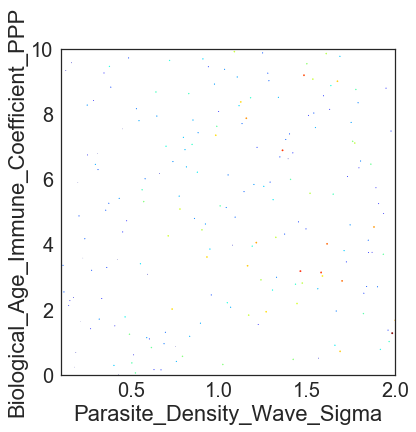

In [9]:
z = pd.merge(samples, results, on='Sample_Id') # Return to Sample_Id

#sub in variables here, can be list of tuples
xyvars = [('Parasite_Density_Wave_Sigma',	'Biological_Age_Immune_Coefficient_PPP'
)]
for (xvar, yvar) in xyvars:
    fig = plt.figure(figsize=(6,6))
    plt.scatter(z[xvar], z[yvar], c=100*z['Sim_Result'], s=5*z['Sim_Result'], cmap='jet')
    plt.xlabel(xvar); plt.ylabel(yvar)
    plt.xlim([param_info.loc[xvar, 'Min'], param_info.loc[xvar, 'Max']])
    plt.ylim([param_info.loc[yvar, 'Min'], param_info.loc[yvar, 'Max']])
    # TODO: Show as surface and plot desired result as isocline
plt.show()

In [10]:
# Finally we get to do some History Matching!
# Begin by creating an instance of the HistoryMatching class
print(type(results))
ext = 'svg' # Filetype for figures produced by history matching
hm = HistoryMatching(
    cut_name = cut_name,
    param_info = param_info,
    inputs = samples,
    results = results.squeeze(),
    desired_result = desired_result,
    desired_result_var = desired_result_std**2,
    iteration = iteration,
    implausibility_threshold = implausibility_threshold,
    discrepancy_var = discrepancy_std**2,
    training_fraction = training_fraction,
    fig_type = ext
)
hm.save() # Save to disk

<class 'pandas.core.frame.DataFrame'>
Welcome to IDM History Matching!
Found 200 unique parameter configurations, each of which is repeated 1 time(s).
--> Training with 150 unique parameter configurations ( 150  simulations including replicates)
--> Testing  with 50  unique parameter configurations ( 50 simulations including replicates)


Found existing GLM basis with the following terms:


[Term([]),
 Term([EvalFactor('Biological_Age_Immune_Coefficient_TM')]),
 Term([EvalFactor('Scale_Factor_Age_b')]),
 Term([EvalFactor('Parasite_Density_Wave_Sigma')]),
 Term([EvalFactor('Immune_Modifier_Include_Recent_Exposure')]),
 Term([EvalFactor('Immune_Modifier_Include_Malaria_Free_Interval ** 2')]),
 Term([EvalFactor('Scale_Factor_Strain_Diversity_n * Wave_Vs_Infection_Relative_Weight')]),
 Term([EvalFactor('Prevalence_Threshold_For_Diversity * Immune_Modifier_Include_Cumulative_Exposure')]),
 Term([EvalFactor('Scale_Factor_Cum_Exp_shape * Immune_Modifier_Include_Cumulative_Exposure')]),
 Term([EvalFactor('Parasite_Density_Wave_Sigma * Immune_Modifier_Include_Cumulative_Exposure')]),
 Term([EvalFactor('Parasite_Density_Wave_Sigma * Immune_Modifier_Include_Recent_Exposure')]),
 Term([EvalFactor('Immune_Modifier_Include_Age * Immune_Modifier_Include_Strain_Diversity')])]

Would you like to use this basis? [Y]/n: n
Regularize:  0  of  15


C:\conda\envs\history_matching\lib\site-packages\statsmodels\regression\linear_model.py:1510: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


Regularize:  1  of  15
Regularize:  2  of  15
Regularize:  3  of  15
Regularize:  4  of  15
Regularize:  5  of  15
Regularize:  6  of  15
Regularize:  7  of  15
Regularize:  8  of  15
Regularize:  9  of  15
Regularize:  10  of  15
Regularize:  11  of  15
Regularize:  12  of  15
Regularize:  13  of  15
Regularize:  14  of  15


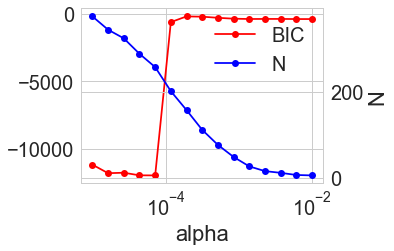

What would you like to use for the GLM regularization parameter, alpha_glm = 2e-3
User selected alpha = 0.002000
Non-Zero: 17 of 406
Regularization for GLM selected:
  * Intercept
 * Biological_Age_Immune_Coefficient_TM
 * Parasite_Density_Wave_Sigma
 * Immune_Modifier_Include_Recent_Exposure
 * Immune_Modifier_Include_Age ** 2
 * Immune_Modifier_Include_Malaria_Free_Interval ** 2
 * Recent_Exposure_Immune_Coefficient_PPP * Scale_Factor_Rec_Exp_steepness
 * Recent_Exposure_Immune_Coefficient_TM * Scale_Factor_Age_b
 * Scale_Factor_Strain_Diversity_n * Scale_Factor_Age_a
 * Scale_Factor_Strain_Diversity_n * Wave_Vs_Infection_Relative_Weight
 * Prevalence_Threshold_For_Diversity * Immune_Modifier_Include_Cumulative_Exposure
 * Scale_Factor_Cum_Exp_shape * Immune_Modifier_Include_Cumulative_Exposure
 * Scale_Factor_Cum_Exp_shape * Immune_Modifier_Include_Malaria_Free_Interval
 * Concurrent_Infections_c * Parasite_Density_Wave_Sigma
 * Parasite_Density_Wave_Sigma * Immune_Modifier_Include_

In [11]:
try:
    existing_basis = True
    need_basis = True
    with open(os.path.join('Cuts', cut_name, 'basis_glm.json')) as data_file:
        config = json.load( data_file )
        basis_glm = Basis.deserialize(config['Basis'])
        fitted_values = pd.read_json(config['Fitted_Values'], orient='split').set_index(['Sample_Id', 'Sim_Id']).squeeze()
except:
    existing_basis = False
    
if existing_basis:
    print('Found existing GLM basis with the following terms:')
    display(basis_glm.model_terms)
    reply = input('Would you like to use this basis? [Y]/n: ')
    
    if reply.lower() != 'n':
        need_basis = False
    
if need_basis:
    basis_glm = Basis.polynomial_basis(params=param_names, intercept = True, first_order=True, second_order=True, third_order=False, param_info=param_info)

    basis_glm.plot_regularize(samples, results, alpha = np.logspace(-5, -2, 15), scaleX=True)
    alpha_glm = float(input('What would you like to use for the GLM regularization parameter, alpha_glm = '))
#     alpha_glm = 1e-1
    
    fitted_values = basis_glm.regularize(samples, results, alpha = alpha_glm, scaleX=True)
    print('Regularization for GLM selected:\n', ' *','\n * '.join(basis_glm.get_terms()))
    with open(os.path.join('Cuts', cut_name, 'basis_glm.json'), 'w') as fout:
        json.dump( {
            'Basis': basis_glm.serialize(),
            'Fitted_Values': fitted_values.reset_index().to_json(orient='split')
        }, fout, indent=4)

In [12]:
# Now fit the glm and plot

### GLM ###############################################################
print("="*80, "\nGeneralized Linear Modeling\n", "="*80)
#######################################################################
f = hm.glm(
    basis = basis_glm,
    family = 'Poisson',
    force_optimize_glm = True,
    glm_fit_maxiter = 1000,
    plot = True, #force_optimize_glm,
    plot_data = True
)

Generalized Linear Modeling
Plotting


In [13]:
for file in glob.glob(fix_glob(os.path.join(hm.glmdir, "PairwiseResults", "*.%s"%ext))):
    img = IFrame(file, width=800, height=600)
    print(file)
    display(img)

In [14]:
# Results get saved to disk, so load and display:
for file in glob.glob(fix_glob(os.path.join(hm.glmdir, "GLM Predicted vs Actual*.%s"%ext))):
    img = IFrame(file, width=800, height=600)
    print(file)
    display(img)

..\iter0\Cuts\500_8_W2_Sugungum\GLM\GLM Predicted vs Actual.svg


In [15]:
basis_gpr = Basis.polynomial_basis(
#     params =  [
# 'Scale_Factor_Age_a', 
# 'Cumulative_Exposure_Immune_Coefficient_TM',
# 'Recent_Exposure_Immune_Coefficient_PPP',
# 'Recent_Exposure_Immune_Coefficient_TM',
# 'Parasite_Density_Wave_Sigma',
# 'Immune_Modifier_Include_Age',
# 'Immune_Modifier_Include_Strain_Diversity',
# 'Immune_Modifier_Include_Cumulative_Exposure'
#               ],
    params = param_info.index.values, 
    intercept = False, 
    first_order = True, 
    param_info=param_info)

In [16]:

### GPR ###############################################################
print("="*80, "\nGaussian Process Regression\n", "="*80)
#######################################################################
hm.gpr(
    basis = basis_gpr,
    force_optimize_gpr = True,

    sigma2_f_guess = 0.6,
    sigma2_f_bounds = (0.1, 1000),
    sigma2_n_guess =  2.0,
    sigma2_n_bounds = (0.01, 100),

    #lengthscale_guess = [7.49636161e+01 4.30910765e-02 2.18296911e+01 8.08185597e+01
#  5.86791240e-02 4.55925184e+01 7.61216580e+01 3.72424498e-01
#  9.24611775e-01 7.41104089e-01]
    lengthscale_guess = 0.25,
    lengthscale_bounds = (0.01, 100),

    optimize_sigma2_n = True,
    log_transform = False,

    verbose = True,
    optimizer_options = {
        'eps': 5e-3,
        'disp': True,
        'maxiter': 15000,
        'ftol': 2 * np.finfo(float).eps,
        'gtol': 2 * np.finfo(float).eps,
    },
    plot = True, #force_optimize_gpr,
    plot_data = False
)

Gaussian Process Regression
Fitting the GPR

	LL: 238.33961439176727 
	Theta: [0.6  2.   0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 0.25] 
	Deriv: [ 1.77407052e+01  1.77595189e+01 -3.83576404e-02 -9.19060100e-03
  8.17618679e-03 -1.54654960e-02 -2.19606103e-02 -1.78932205e-02
 -5.90004606e-03 -2.03329635e-02 -1.34138060e-02 -3.75295147e-02
  8.16716752e-03  7.15630520e-03 -5.08885767e-03  1.40280115e-03
 -1.18219690e-02 -2.18448446e-04 -3.12928401e-02 -1.88066878e-02
 -1.90288846e-02 -2.36096389e-02 -1.61515489e-02  2.41420680e-02
 -1.10592632e-02  8.38867423e-03 -2.79676446e-03  3.04461281e-02
  3.25513953e-03]

	LL: 652.4468673505786 
	Theta: [0.1        0.01       0.28835764 0.2591906  0.24182381 0.2654655
 0.27196061 0.26789322 0.25590005 0.27033296 0.26341381 0.28752951
 0.24183283 0.24284369 0.25508886 0.2485972  0.26182197 0.25021845
 0.28129284 0.26880669 0.26902888 0.27360964 0.26615155 0.


	LL: 212.52870899044927 
	Theta: [0.52123281 0.57990775 0.52633283 0.33428245 0.20116199 0.37807185
 0.42089151 0.40464546 0.32779987 0.41520608 0.38319989 0.5333353
 0.22112183 0.21266948 0.31510267 0.25021029 0.36697306 0.28384304
 0.51174315 0.41391999 0.40726218 0.44760329 0.38278834 0.05177747
 0.36329105 0.1893692  0.28926013 0.01       0.23702418] 
	Deriv: [ 6.18331087e+00  7.40619568e+00 -2.30496605e-01 -2.24584089e-01
 -2.84606321e-01 -2.17009221e-01 -2.25710101e-01 -2.44477123e-01
 -3.43746778e-01 -2.40358840e-01 -3.14327163e-01 -2.56394083e-01
 -5.05108910e-01 -3.01310481e-01 -2.94669477e-01 -2.39656033e-01
 -2.72138701e-01 -3.07555337e-01 -2.78497410e-01 -2.52395664e-01
 -2.49262655e-01 -2.79745688e-01 -2.08784004e-01 -2.12867685e-02
 -2.99521602e-01 -1.35944603e-01 -2.72222979e-01  1.14386284e-19
 -9.82854823e-02]

	LL: 213.31261993071166 
	Theta: [1.23006599 0.11799354 1.23883679 0.55727234 0.07960332 0.71336451
 0.86536555 0.81107828 0.53955988 0.8467922  0.73776695 1.2


	LL: 197.53517081421657 
	Theta: [0.83054236 0.01       2.75725205 1.09647907 0.53643873 1.50253013
 1.90153625 1.77465425 1.37895684 1.87065496 1.73646952 2.83094512
 1.33614032 0.70188867 1.21167164 0.50172837 1.57473976 0.95090813
 2.67107127 1.87573913 1.82348987 2.21223773 1.56930172 0.06293472
 1.5795909  0.01       1.21247548 0.01       0.7942008 ] 
	Deriv: [-1.68174090e+01 -1.30975403e+01 -3.44210467e-01  6.61920162e-01
  6.83700527e+00  4.31730932e-01  9.04841815e-03  5.23629459e-02
 -1.26046481e-01 -2.11046987e-03 -6.96429094e-01 -3.30733432e-01
 -6.09247095e-01  1.18571037e+00 -1.64643316e-01  9.59840487e-01
 -2.50255434e-01  1.35327405e+00 -1.66469657e-01 -3.44937041e-01
  8.64571387e-02 -5.44393841e-01 -8.30733574e-02 -7.01425307e+00
  5.04896080e-01 -1.43220161e-18 -6.51358998e-01  1.03613237e-18
  1.04453627e-01]

	LL: 196.23100009169053 
	Theta: [1.15226549 0.01       3.07016039 1.18022718 0.48408259 1.63976518
 2.09170008 1.94930069 1.47340979 2.05655007 1.90040174 3.


	LL: 190.91065032721406 
	Theta: [1.59136932 0.01       6.75384342 2.30832168 0.22723761 3.41534497
 4.49576679 4.18062244 3.20006611 4.42033697 4.20806928 6.94184941
 3.33211128 1.48386815 2.75927303 0.89487161 3.71705244 1.77967332
 6.51275667 4.50015434 4.30827934 5.39916662 3.65403471 0.12670595
 3.6506258  0.11814847 2.90045789 0.54054144 1.79816158] 
	Deriv: [ 2.56384313  6.04179659 -0.02596836  0.34357064 -1.12829321  0.26660788
  0.05477113 -0.03279286 -0.0124459   0.05021424 -0.22715471 -0.05645547
 -0.28569491 -0.18189007  0.37144731 -1.40380545  0.06415341  1.30590397
 -0.0696272  -0.15286552 -0.14506449 -0.20047793  0.08093122  2.42983769
  0.07145489 -0.11725903 -0.18120645  0.56432539 -0.34397346]

	LL: 190.4455795388497 
	Theta: [1.47987627 0.01       6.5307048  2.20424008 0.17503763 3.28628363
 4.34490713 4.04820489 3.11226935 4.27235103 4.10003012 6.7140622
 3.28932784 1.46578991 2.65366305 0.97822022 3.59976607 1.62159347
 6.30082601 4.37001839 4.18288409 5.2434424  


	LL: 188.7414193093246 
	Theta: [1.16532237 0.01       4.89717748 1.50518259 0.16171648 2.33530863
 3.23922921 3.05813629 2.37463356 3.20019647 3.22504445 5.04569744
 2.7248935  1.15723463 1.86950805 1.32007617 2.72321948 0.6691824
 4.74612565 3.36531339 3.22011807 4.04849587 2.64287611 0.10135334
 2.64585841 0.03941778 2.2644285  0.42381548 1.52140491] 
	Deriv: [ 2.31931046e+00  1.27771388e+01 -3.32671951e-02  3.26035282e-01
 -8.65107435e-01  6.05525606e-01 -2.35693446e-02 -5.34407653e-02
  1.26290746e-01 -9.59928340e-02 -2.58872062e-01 -9.62949946e-02
 -3.56295623e-01 -2.26608304e-01  2.75627290e-01 -4.73743018e-01
 -7.33406061e-02  1.06609631e-02 -1.03660861e-01 -2.14961703e-01
 -1.66514464e-01 -3.04098265e-01 -4.97614541e-02 -6.30525153e-01
 -5.56420693e-02 -1.21925432e-03 -8.27980867e-02 -1.67003446e-02
 -4.60022779e-01]

	LL: 188.52106918990228 
	Theta: [1.16306747 0.01       5.08531435 1.54169339 0.16221928 2.40559388
 3.35895079 3.17316655 2.46740411 3.32024109 3.3614118  5.24


	LL: 186.78986969536936 
	Theta: [1.81047944 0.01       9.48866828 2.16286728 0.24170404 3.7263891
 6.15940933 5.87634104 4.41073993 6.14320103 6.51481592 9.84350634
 5.92220338 2.48586501 3.13349309 2.9726752  5.22614853 0.59369447
 9.24648235 6.71463371 6.33502284 8.15149794 4.97623457 0.14252782
 5.03924666 0.20517376 4.5482564  0.57905263 3.3487357 ] 
	Deriv: [ 0.00716022 -0.06854409  0.01176139  0.49005858  1.17544743  0.51718144
  0.08984127 -0.01548396  0.25020129  0.06559738 -0.0307875  -0.03271177
 -0.08613032 -0.36632965  0.29920027  0.07413411  0.00830954 -0.85508628
 -0.02429358 -0.18653767 -0.12367767 -0.13851929  0.11874254 -0.30735997
 -0.0575641  -0.60165791  0.0384093  -0.17797384  0.0223194 ]

	LL: 186.7255650540333 
	Theta: [1.85278877e+00 1.00000000e-02 9.74012351e+00 2.14279286e+00
 2.46142717e-01 3.74193983e+00 6.31339825e+00 6.03361453e+00
 4.50477974e+00 6.30284666e+00 6.71414168e+00 1.01116573e+01
 6.13131291e+00 2.59373193e+00 3.16305243e+00 3.10232242e+00
 5


	LL: 184.375780881792 
	Theta: [1.33873187 0.01       8.12176204 0.27526722 0.15920951 1.16527703
 5.01375354 5.13392874 3.16442691 5.18592947 6.18694907 8.61001795
 6.15114173 3.09408436 1.47599384 3.87504086 4.51564984 0.49614157
 8.09274188 6.51181287 5.97202852 7.77228144 4.01275789 0.13108869
 4.40375586 0.13322764 4.13799569 1.04054864 3.48430559] 
	Deriv: [ 1.35592652e+00  1.38528644e+01 -2.05712336e-03 -5.49051880e+00
 -4.21820244e+00  6.87470349e-01 -1.25656379e-02 -6.82151239e-02
  5.04771767e-01 -1.08918314e-02 -7.55134156e-02 -1.83314135e-02
 -8.02636215e-02 -2.12849248e-01 -1.04767557e-01 -1.91538957e-01
  3.30804932e-02 -3.65048220e+00 -1.65136714e-02 -1.70439220e-01
 -1.50812157e-01 -1.40741732e-01 -1.47936072e-01  8.88949120e+00
 -1.90489286e-01  3.04278987e+00  1.20628318e-01  2.62739440e+00
  5.95930159e-02]

	LL: 184.37312284951543 
	Theta: [1.33409921 0.01       7.6406078  0.67444374 0.15867842 1.63787983
 4.78811105 4.81083548 3.12956666 4.89855026 5.64847645 8.05


	LL: 181.72901646752638 
	Theta: [1.59802827e+00 1.00000000e-02 1.17565472e+01 1.48263597e+00
 1.14776988e-01 5.04128315e-01 7.12293985e+00 7.47273524e+00
 4.17067846e+00 7.47738272e+00 9.31479786e+00 1.25751088e+01
 9.64663890e+00 5.12780285e+00 1.38942449e+00 6.20145481e+00
 6.50313860e+00 8.18026880e-01 1.18101491e+01 9.85855604e+00
 8.92913161e+00 1.17300977e+01 5.65250693e+00 1.39881246e-01
 6.41981305e+00 2.30568776e-01 6.14498660e+00 8.16054946e-01
 5.52746062e+00] 
	Deriv: [ 4.20750106e-01  5.76216034e+00  2.30100578e-02 -3.21537259e-01
  1.71441864e+00 -5.42449275e-01  4.11729447e-02 -7.51292308e-02
  3.86584564e-01 -2.98750205e-02 -2.67303248e-02  2.16185821e-03
 -5.95228156e-02  2.64510894e-02  3.90823758e-01 -1.92374188e-01
  9.86906972e-02  1.02569983e+00  1.31803650e-02 -9.17362353e-02
 -8.22878051e-02 -3.42556957e-02 -1.61398203e-02 -3.56343614e-01
 -9.81025927e-02 -1.03730233e+00  2.04652392e-01 -2.27917576e-01
  7.33678413e-02]

	LL: 181.66799410581004 
	Theta: [1.642


	LL: 181.220894454656 
	Theta: [1.59140375e+00 1.00000000e-02 1.25845686e+01 2.68551164e+00
 1.10847979e-01 4.04839980e-01 7.58968061e+00 8.05516798e+00
 4.24991375e+00 8.02166153e+00 1.00892523e+01 1.34994229e+01
 1.05744506e+01 5.66999752e+00 1.20431631e+00 6.88971533e+00
 6.93118776e+00 6.58762934e-01 1.26710188e+01 1.07120082e+01
 9.67510943e+00 1.27002551e+01 6.02647540e+00 1.55527625e-01
 6.94322775e+00 2.76378034e-01 6.56995754e+00 7.32224312e-01
 6.04775385e+00] 
	Deriv: [-7.29436743e-02  8.23534432e+00  2.65476931e-02 -1.85014307e-01
  1.38935114e+00 -1.02592764e+00  4.66082926e-02 -7.96010323e-02
  3.33322386e-01 -3.22131900e-02 -2.35513874e-02  4.65705397e-03
 -5.21829594e-02  8.88470517e-02  2.01022175e-01 -1.33282265e-01
  1.14823082e-01 -7.48784663e-01  1.75303539e-02 -8.44940021e-02
 -6.55472464e-02 -3.05824584e-02 -3.53740115e-03  1.51739851e+00
 -1.26929457e-01 -1.10056046e+00  2.89489151e-01 -6.57245969e-01
  4.76359002e-02]

	LL: 181.04066968018535 
	Theta: [1.53669


	LL: 180.63657673018753 
	Theta: [2.05502249e+00 1.00000000e-02 1.60948552e+01 7.10764571e+00
 1.02513296e-01 5.13114183e-01 9.57399811e+00 1.05491886e+01
 4.54937887e+00 1.03641415e+01 1.32874308e+01 1.73979842e+01
 1.43249625e+01 7.63948019e+00 7.49092645e-01 9.65616205e+00
 8.67980673e+00 9.16379096e-01 1.62943307e+01 1.42363032e+01
 1.27751168e+01 1.66951279e+01 7.67531426e+00 1.75801700e-01
 9.21576283e+00 4.03235747e-01 8.12604782e+00 1.16677107e+00
 8.08450762e+00] 
	Deriv: [ 1.58845794e+00  1.18891841e+01  1.77690634e-02 -4.49014585e-02
 -2.80966902e+01 -1.23806712e+00  5.45072829e-02 -9.19994727e-02
  1.64808029e-01 -5.83323667e-02 -4.52477282e-02  3.70099942e-03
 -4.40900332e-02  9.78046864e-02 -1.28487638e+00 -7.94627058e-02
  2.15487447e-01 -2.52322142e-01  2.51848153e-02 -7.12799647e-02
 -6.89508020e-02 -2.00147711e-02 -5.60055136e-02 -5.99435494e+00
 -1.46301049e-01  9.09576666e-01  2.89179843e-01  6.62994199e-01
 -2.74814524e-02]

	LL: 180.23024202527085 
	Theta: [1.827


	LL: 179.75775358428848 
	Theta: [2.27482698e+00 1.00000000e-02 1.89750705e+01 1.15253736e+01
 1.46306881e-01 5.89239869e-01 1.11355201e+01 1.26950869e+01
 4.57876221e+00 1.23207035e+01 1.60188283e+01 2.06303098e+01
 1.76007371e+01 9.34724504e+00 6.21370470e-01 1.21429253e+01
 9.97992228e+00 8.99580925e-01 1.92830518e+01 1.72940676e+01
 1.54539214e+01 2.00987715e+01 9.03031694e+00 1.93805260e-01
 1.12215652e+01 3.03473230e-01 9.23346145e+00 1.07377084e+00
 9.85889320e+00] 
	Deriv: [ 0.29238128  0.41586865  0.01356913 -0.03181934  0.31750424  0.98417121
  0.07766592 -0.06976504  0.08355534 -0.00408859 -0.02071085  0.00643054
 -0.04250345  0.04799136 -0.5447256  -0.02958586  0.1923131  -0.42331747
  0.03031249 -0.05274379 -0.05701757 -0.02051398 -0.02613388 -0.40173524
 -0.11444327 -0.80984741  0.24741685 -0.17051519 -0.01574414]

	LL: 179.7091573231869 
	Theta: [2.40082244e+00 1.00000000e-02 2.04474342e+01 1.29835900e+01
 1.49644947e-01 5.89653569e-01 1.19636116e+01 1.37319631e+01
 4.7


	LL: 179.37112910020008 
	Theta: [ 2.55757918  0.06536289 27.21076151 22.34112756  0.17019445  0.58503523
 15.66108104 18.69879824  5.11408237 17.85458086 23.65524038 29.8086415
 26.64749464 14.04438498  0.64304363 18.86061929 13.79234595  1.18746497
 27.78374136 25.76824669 22.91036004 29.62103045 12.92325629  0.21579209
 16.78311893  0.33913468 12.56031978  1.15939216 14.79976735] 
	Deriv: [-1.93055081e-01  1.60614836e+00  3.66632226e-03 -1.29325735e-02
  5.33294168e-01 -4.56697987e-01  6.59647121e-02 -4.81251972e-02
 -5.67957026e-02  5.56930135e-04 -3.99608584e-03  1.14959777e-03
 -2.53146348e-02  4.50628842e-02 -2.55224509e-01 -1.66488300e-02
  1.50330617e-01  1.64580581e-01  1.43852790e-02 -2.77896144e-02
 -3.95203251e-02 -1.49148334e-02 -2.35416823e-02  5.98262926e-01
 -6.27406705e-02  2.18581316e-02  2.26584140e-01 -1.34569426e-01
 -3.72178492e-02]

	LL: 179.3335943095709 
	Theta: [ 2.71797459  0.06905637 29.87941642 25.61494686  0.17488104  0.62976974
 17.13757643 20.62685009 


	LL: 179.22390931142613 
	Theta: [ 2.99221528  0.07012315 34.46564734 33.58866071  0.18232361  0.62058948
 19.54183929 24.15321373  5.20595642 22.78387713 30.55268453 37.9553823
 34.94349807 18.33857601  0.72086785 25.15389163 16.93804135  1.25264577
 35.3022477  33.51123418 29.70454307 38.22120611 16.35781798  0.2239701
 21.90319202  0.35882038 15.16968476  1.13982849 19.31041895] 
	Deriv: [-0.05849189 -0.29543269  0.00345266 -0.00738956 -0.10501201 -0.1504646
  0.05658512 -0.03575211 -0.13848703  0.00656795 -0.00103063  0.0022474
 -0.01838138  0.03496302  0.53126591 -0.0118316   0.12853354  0.0409267
  0.01313713 -0.01921506 -0.02929092 -0.01086627 -0.02222702 -0.08763436
 -0.0496584  -0.07569569  0.19491851 -0.52275781 -0.03547856]

	LL: 179.19127841282813 
	Theta: [ 2.86193413  0.05813933 31.23604216 30.43533183  0.1817293   0.5703731
 17.69789751 21.90263986  4.77948276 20.64553045 27.66459573 34.39364989
 31.60477173 16.59787512  0.76612218 22.7524183  15.30711599  1.1273458
 31


	LL: 178.9734937440977 
	Theta: [2.33736956e+00 1.00000000e-02 2.12755300e+01 2.01470371e+01
 1.39687049e-01 4.35633514e-01 1.20609723e+01 1.48957769e+01
 3.57455771e+00 1.40330530e+01 1.86982345e+01 2.33871907e+01
 2.11923053e+01 1.11843833e+01 8.17924763e-01 1.52158285e+01
 1.03813434e+01 8.21643355e-01 2.17518440e+01 2.05453440e+01
 1.82578245e+01 2.34353579e+01 1.01445055e+01 1.96064017e-01
 1.34875752e+01 3.60246863e-01 9.18098670e+00 1.04092186e+00
 1.17609480e+01] 
	Deriv: [ 0.43020206  4.98576266  0.01247007 -0.01421304 -2.96294516 -1.8072806
  0.0605788  -0.05864867 -0.16311203 -0.00872732 -0.01668995  0.0112209
 -0.02774512  0.08251734  0.37225163 -0.03153259  0.19763512 -0.73825362
  0.02565326 -0.04055428 -0.03992283 -0.01488954 -0.02182099 -0.52779879
 -0.09682827 -0.48006386  0.29732183 -0.08724702 -0.01847617]

	LL: 178.8992388624875 
	Theta: [2.21591169e+00 1.00000000e-02 1.98183342e+01 1.90501293e+01
 1.40675434e-01 4.15336173e-01 1.12151448e+01 1.39056266e+01
 3.3184


	LL: 178.2773455767659 
	Theta: [2.64179407e+00 1.00000000e-02 2.38629945e+01 3.12376513e+01
 1.50626651e-01 5.58132254e-01 1.29183903e+01 1.75846448e+01
 2.62435818e+00 1.60125898e+01 2.18608767e+01 2.65378514e+01
 2.55270926e+01 1.32651836e+01 7.97620725e-01 1.89938090e+01
 1.03724865e+01 9.44588151e-01 2.45293930e+01 2.44689720e+01
 2.16505933e+01 2.73800831e+01 1.14558418e+01 2.06429695e-01
 1.63367472e+01 4.53064578e-01 8.45604268e+00 1.34910101e+00
 1.40706384e+01] 
	Deriv: [ 0.02647458 -0.66312544  0.00759213 -0.00724537  5.27008368  0.39109613
  0.06844675 -0.05080866 -0.70354479 -0.00681266 -0.0209381   0.00963772
 -0.02351009  0.07888205  0.86426498 -0.02309597  0.247062    0.27113442
  0.02968196 -0.03514333 -0.03678058 -0.01224609 -0.03209412  0.99409153
 -0.09172196 -0.3815783   0.27951272  0.43966719 -0.00925424]

	LL: 178.1969168481412 
	Theta: [2.49350267e+00 1.00000000e-02 2.17472318e+01 2.95855434e+01
 1.38619217e-01 5.28402882e-01 1.16898233e+01 1.61449330e+01
 2.27


	LL: 176.59605697973174 
	Theta: [2.66861954e+00 1.00000000e-02 2.29919568e+01 4.49304825e+01
 1.18649469e-01 5.34861112e-01 1.11188437e+01 1.87075902e+01
 2.61225479e+00 1.59560746e+01 2.25977377e+01 2.60855430e+01
 2.75477499e+01 1.36390375e+01 8.35603084e-01 2.15888476e+01
 6.77658770e+00 1.65135134e+00 2.37712226e+01 2.61443242e+01
 2.30380259e+01 2.82837086e+01 1.13517435e+01 2.17348236e-01
 1.82190953e+01 9.91091822e-01 3.66858192e+00 1.42979870e+00
 1.50896611e+01] 
	Deriv: [ 3.68863041e-01  9.35309881e+00  7.26101461e-03 -4.77929942e-03
 -1.06771825e+00 -1.85271560e+00  5.74851270e-02 -3.40847559e-02
 -4.00546583e-01 -4.64874996e-02 -4.02391520e-02 -3.74002518e-03
 -1.87215746e-02  1.09579545e-01  3.54743096e-02 -4.33172401e-02
  4.55969432e-01  1.89472608e+00  8.28716942e-03 -3.35552280e-02
 -2.17598344e-02 -1.19281262e-02 -5.26957981e-02 -1.68156268e+00
 -9.51199014e-02  6.12273691e-01 -8.31245767e-02  4.57451304e-01
  2.92713471e-02]

	LL: 176.52952893285422 
	Theta: [2.620


	LL: 175.1156609871421 
	Theta: [4.14804420e+00 1.00000000e-02 3.77634727e+01 7.66997865e+01
 1.19115555e-01 7.36203031e-01 1.78635169e+01 3.11731608e+01
 4.72511373e+00 2.63905996e+01 3.76776299e+01 4.30069688e+01
 4.63769813e+01 2.25087981e+01 9.95373745e-01 3.65432907e+01
 9.95600788e+00 1.32860748e+00 3.90907054e+01 4.36719617e+01
 3.84150629e+01 4.70668411e+01 1.87217201e+01 2.96384196e-01
 3.06037336e+01 1.37452710e+00 5.09485792e+00 1.68303742e+00
 2.53265475e+01] 
	Deriv: [ 6.85934810e-01  1.74281922e+01  1.05252470e-02 -5.40892628e-03
 -4.83208181e+00 -2.55834360e-01  3.21110843e-02 -2.08906587e-02
  3.01721009e-02 -3.24609730e-02 -3.08124432e-02  1.29750422e-03
 -9.56358899e-03  6.59448133e-02  3.18069375e-01 -1.77559662e-02
  2.49957406e-01  4.93551687e-02  1.67353073e-02 -2.15744219e-02
 -1.45423649e-02 -6.82564189e-03 -4.65652455e-02  1.52851539e+00
 -7.39207019e-02  6.02538478e-01 -6.89055837e-02  2.11427062e-01
  1.93184070e-02]

	LL: 175.10651620470867 
	Theta: [4.1229


	LL: 174.7727757686789 
	Theta: [3.77194944e+00 1.00000000e-02 3.83311123e+01 7.95610281e+01
 1.19869355e-01 7.18910008e-01 1.78932851e+01 3.19216926e+01
 5.59617788e+00 2.68903087e+01 3.84677232e+01 4.37186116e+01
 4.74645137e+01 2.28129321e+01 8.02759908e-01 3.75207520e+01
 9.30621601e+00 1.32361285e+00 3.96718537e+01 4.46832145e+01
 3.92986696e+01 4.80259501e+01 1.91065665e+01 3.04822042e-01
 3.14984782e+01 1.33150543e+00 4.44148718e+00 1.40038681e+00
 2.58997077e+01] 
	Deriv: [ 4.45597158e-02  7.06584157e+00  1.44734614e-02 -5.26099519e-03
 -1.26836525e+00  2.22422479e-01  4.20039834e-02 -1.54697152e-02
  1.50550315e-01 -2.65480186e-02 -2.68224812e-02  1.78339839e-04
 -1.00596010e-02  7.23586784e-02 -3.86724257e-01 -1.34577415e-02
  2.85847456e-01 -5.20482851e-02  1.90321373e-02 -1.89872388e-02
 -1.06514671e-02 -3.85051897e-03 -4.86366487e-02  8.05563602e-01
 -6.30938025e-02  1.36046365e+00 -2.02586154e-01 -2.99991787e-01
  2.43712070e-02]

	LL: 174.72040181453357 
	Theta: [3.5464


	LL: 174.07552372644943 
	Theta: [3.36095401e+00 2.13541359e-02 4.14434939e+01 8.85092486e+01
 1.36501346e-01 5.93085716e-01 1.90766958e+01 3.48481151e+01
 6.39089065e+00 2.92217128e+01 4.19288143e+01 4.73722934e+01
 5.19056117e+01 2.47033814e+01 6.94836342e-01 4.12006336e+01
 9.08013805e+00 1.20532808e+00 4.29093627e+01 4.88009621e+01
 4.28896499e+01 5.22893645e+01 2.07763969e+01 2.93151780e-01
 3.45925625e+01 6.97799078e-01 4.29007105e+00 1.23808090e+00
 2.82575469e+01] 
	Deriv: [ 5.09512300e-01  3.18422763e+00  9.64567233e-03 -3.92672510e-03
 -4.26037653e+00 -4.93825608e-01  2.43370812e-02 -1.60794152e-02
  7.34502597e-02 -1.01412678e-02 -1.47828855e-02  1.41236000e-03
 -1.03565627e-02  5.23888122e-02  5.46607497e-01 -8.66508652e-03
  2.79146648e-01 -1.67842527e-01  2.20699057e-02 -1.30742282e-02
 -9.51205444e-03 -4.31069977e-03 -3.24409558e-02 -5.68062729e-01
 -4.30024209e-02 -4.15004502e-01 -3.90764359e-01 -7.96208173e-01
  1.14797505e-02]

	LL: 174.03994044545055 
	Theta: [3.459


	LL: 173.75786178747126 
	Theta: [4.43931675e+00 6.35592463e-02 6.65048097e+01 1.00000000e+02
 1.64031174e-01 7.40535541e-01 3.03612835e+01 5.61789749e+01
 1.11333960e+01 4.70324906e+01 6.76639538e+01 7.61153987e+01
 8.40507963e+01 3.95725598e+01 6.59594742e-01 6.67783137e+01
 1.35997685e+01 1.68743256e+00 6.88673256e+01 7.87353109e+01
 6.91436945e+01 8.42818318e+01 3.34254700e+01 3.63353291e-01
 5.59574954e+01 6.70421730e-01 6.52936916e+00 1.49207922e+00
 4.56823434e+01] 
	Deriv: [ 2.78035559e-01  1.17323640e+00  3.41284788e-03 -4.06915089e-03
 -9.95300407e-01 -2.76696053e-01  2.00084582e-02 -1.24428786e-02
  6.24643980e-02 -2.39494627e-03 -5.73457829e-03 -2.40106926e-04
 -6.84598635e-03  2.29671046e-02 -4.01586963e-01 -2.60130232e-03
  1.57990169e-01 -4.44345729e-02  1.43340375e-02 -6.66725050e-03
 -8.66178738e-03 -2.69083209e-03 -1.87762554e-02  3.50263518e-01
 -1.91145191e-02 -2.96369620e-01 -1.38363520e-01 -1.13775417e-01
 -5.34243405e-03]

	LL: 173.73381621443315 
	Theta: [4.360


	LL: 173.65916248868223 
	Theta: [4.60134480e+00 8.00486947e-02 7.84389685e+01 1.00000000e+02
 1.69064474e-01 7.79429387e-01 3.53450665e+01 6.68377203e+01
 1.34794967e+01 5.56806542e+01 8.03628885e+01 8.99502413e+01
 1.00000000e+02 4.68275012e+01 6.77446063e-01 7.98691305e+01
 1.45981340e+01 1.87236453e+00 8.12548483e+01 9.37081750e+01
 8.22529581e+01 9.99523562e+01 3.95737773e+01 3.77244266e-01
 6.68595824e+01 6.70546902e-01 6.59127177e+00 1.62544268e+00
 5.43899197e+01] 
	Deriv: [-6.31400929e-03 -1.16221364e+00  2.18393012e-03 -4.09753911e-03
  2.95469073e-01  1.28584149e-01  1.81274361e-02 -1.00023070e-02
  7.98976491e-02 -1.66736365e-03 -3.80325659e-03 -7.11933068e-04
 -5.33308036e-03  1.92035313e-02  1.12927495e-01 -2.05339679e-03
  1.48267102e-01  2.33845585e-02  1.21180964e-02 -5.11946265e-03
 -7.21919599e-03 -2.22841769e-03 -1.43777258e-02  2.53804006e-01
 -1.34425426e-02 -7.39174371e-02 -1.74429916e-01  1.35451845e-01
 -4.09036847e-03]

	LL: 173.65081621602397 
	Theta: [4.605


	LL: 173.38977076368604 
	Theta: [4.01087433e+00 9.39536888e-02 7.90264734e+01 1.00000000e+02
 1.76072901e-01 6.83544112e-01 3.49799934e+01 6.80993539e+01
 1.29491900e+01 5.63601682e+01 8.16429147e+01 9.08585002e+01
 1.00000000e+02 4.73536363e+01 5.91560057e-01 8.18049649e+01
 1.22326934e+01 1.71033755e+00 8.18579365e+01 9.54786779e+01
 8.37788336e+01 1.00000000e+02 4.01304246e+01 3.75705592e-01
 6.84677708e+01 6.21062300e-01 6.46399421e+00 1.54088113e+00
 5.54045886e+01] 
	Deriv: [-1.73909292e-01  2.90217003e+00  1.25811710e-03 -3.57401758e-03
  2.39331295e+00 -1.34619945e+00  1.89279064e-02 -8.74677446e-03
  9.19322714e-02 -1.54335892e-03 -1.04746818e-03 -8.63205750e-04
 -4.65196367e-03  1.80126376e-02 -2.16378973e+00 -9.46026420e-04
  1.63245271e-01 -1.92890832e-01  9.44442190e-03 -4.16557846e-03
 -6.38451794e-03 -2.59117541e-03 -1.12673783e-02  1.83931179e+00
 -1.00297949e-02  8.55072312e-01 -8.12213146e-02  1.08497773e-01
 -8.96897500e-03]

	LL: 173.82741685035688 
	Theta: [3.499


	LL: 171.79551008551192 
	Theta: [3.27933234e+00 7.62869388e-02 8.26558745e+01 1.00000000e+02
 1.54578633e-01 6.69127135e-01 3.41474071e+01 7.41835998e+01
 8.62176854e+00 5.99245271e+01 8.80705355e+01 9.59883444e+01
 1.00000000e+02 5.04854125e+01 6.76922224e-01 9.09220205e+01
 3.03493270e+00 1.19822712e+00 8.56085707e+01 1.00000000e+02
 9.12332644e+01 1.00000000e+02 4.29280192e+01 2.62322112e-01
 7.58112068e+01 4.31649066e-01 7.38431234e+00 2.29127502e+00
 6.04319853e+01] 
	Deriv: [-6.32194475e-01 -3.65772474e+00 -5.41226912e-04 -3.60265254e-03
  2.47739061e+00  3.60277859e-01  1.73667933e-02 -9.03608706e-03
  1.09208767e-01 -4.59991392e-03  1.36966485e-03 -3.38313357e-04
 -3.83653244e-03  1.81083712e-02  3.99646393e-01 -2.98875273e-03
  2.12387596e-01 -1.38708329e+00  1.02618046e-02 -2.81291649e-03
 -5.65345533e-03 -2.51560862e-03 -4.44107856e-03  1.28656453e+00
 -8.56779603e-03 -7.72452190e-01  1.14891620e-01  1.18545414e+00
  3.66661317e-03]

	LL: 171.63248111718755 
	Theta: [3.302


	LL: 169.46582156931092 
	Theta: [4.59361009e+00 1.90925129e-02 8.21649908e+01 1.00000000e+02
 2.18862856e-01 7.62062666e-01 3.27938641e+01 7.52745175e+01
 7.22857258e+00 6.00229856e+01 8.89233166e+01 9.58947266e+01
 1.00000000e+02 5.10874246e+01 1.25985064e+00 9.33684268e+01
 9.23431447e-01 3.45744974e+00 8.52387476e+01 1.00000000e+02
 9.26284657e+01 1.00000000e+02 4.29015663e+01 2.77999497e-01
 7.74713699e+01 1.28415343e+00 3.57541901e+00 1.09894706e+00
 6.14493085e+01] 
	Deriv: [-2.11946764e-01  1.64135399e+00 -2.32829320e-03 -7.35638050e-03
  3.58839115e+00 -6.81618456e-01  2.43215078e-02 -8.01846875e-03
  3.79091407e-01 -9.21807340e-03 -1.99125042e-03 -5.96967940e-03
  1.27160011e-03  2.64229981e-02  1.60598189e+00 -8.70795013e-03
 -1.12189394e+00  2.16244214e-01 -4.28746724e-04 -5.00625080e-04
 -5.45424240e-03 -7.56560206e-03 -7.17379478e-04  4.12816893e+00
 -3.01174261e-02  2.55432967e+00  1.37007594e-01  6.74847328e-01
  6.71359739e-03]

	LL: 178.35968348618314 
	Theta: [5.353


	LL: 168.19958050451538 
	Theta: [4.09660285e+00 1.95932408e-02 8.23344496e+01 1.00000000e+02
 2.24504857e-01 8.50278917e-01 3.28494510e+01 7.54131038e+01
 7.44588536e+00 6.01594168e+01 8.90840150e+01 9.60823072e+01
 1.00000000e+02 5.10549869e+01 7.77700257e-01 9.34587930e+01
 1.02941711e+00 3.00710202e+00 8.53832431e+01 1.00000000e+02
 9.27720666e+01 1.00000000e+02 4.30463219e+01 2.60628041e-01
 7.76389774e+01 8.76875216e-01 4.09290280e+00 9.95096572e-01
 6.15201105e+01] 
	Deriv: [-3.96643656e-02  2.77161860e-01 -3.02156597e-03 -6.64279187e-03
 -5.10685111e-03  1.03893437e+00  2.81170593e-02 -8.57287510e-03
  2.32142582e-01 -7.22792064e-03  1.29517304e-03 -4.47895481e-03
 -1.00745119e-03  2.11985512e-02 -5.41163724e-01 -6.76488616e-03
 -1.68716064e-01  2.46956192e-01  1.85928561e-03 -4.31303944e-04
 -5.71581939e-03 -6.88734768e-03 -1.80862174e-04 -1.30054489e+00
 -2.66606408e-02  1.07601262e+00  2.53576485e-01 -2.92358484e-02
 -4.32774511e-03]

	LL: 168.17468378276595 
	Theta: [4.115


	LL: 168.03724104707626 
	Theta: [4.27288208e+00 1.32665772e-02 8.24424592e+01 1.00000000e+02
 2.33647733e-01 7.90278713e-01 3.28293070e+01 7.55896202e+01
 7.10099014e+00 6.02582542e+01 8.92720197e+01 9.62364648e+01
 1.00000000e+02 5.11872017e+01 8.53295998e-01 9.37467275e+01
 1.07237762e+00 3.04299921e+00 8.55024822e+01 9.99999655e+01
 9.29975051e+01 1.00000000e+02 4.31073108e+01 2.55427143e-01
 7.78425840e+01 7.81478856e-01 3.95997379e+00 9.99131874e-01
 6.16812399e+01] 
	Deriv: [ 3.69041900e-01  1.31684784e+00 -3.69293399e-03 -6.93702644e-03
 -3.05480669e-01  2.65488875e-01  2.20243119e-02 -8.71394708e-03
  1.96824290e-01 -7.75742811e-03  1.33351012e-03 -4.60523272e-03
 -1.40508094e-03  2.19494948e-02  6.59152136e-02 -6.97865603e-03
  6.41836507e-02  2.68284619e-01  1.39386969e-03  1.89631903e-04
 -5.76949453e-03 -7.15245055e-03  1.31957006e-03 -2.01444668e+00
 -2.74049524e-02 -4.39985664e-01  1.61398203e-01  6.63321510e-02
 -5.02495193e-03]

	LL: 168.0431528703 
	Theta: [4.1261825


	LL: 167.62161666800682 
	Theta: [3.73920715e+00 1.00000000e-02 8.30694581e+01 1.00000000e+02
 2.30280522e-01 7.02206499e-01 3.27186935e+01 7.65355005e+01
 5.67412550e+00 6.08433330e+01 9.02639285e+01 9.70905109e+01
 1.00000000e+02 5.16633500e+01 1.01560794e+00 9.51361574e+01
 9.17280589e-01 2.32260870e+00 8.61401281e+01 9.99993100e+01
 9.41537801e+01 1.00000000e+02 4.35315392e+01 2.32450835e-01
 7.89919866e+01 7.91561418e-01 3.64330063e+00 8.50687350e-01
 6.24698730e+01] 
	Deriv: [-1.09382268e-01  8.73115720e+00 -3.46960249e-03 -6.05692586e-03
  2.50632730e+00 -8.03818414e-02  1.86929572e-02 -6.76621306e-03
  2.78252120e-01 -5.91421161e-03  8.81434360e-04 -3.93483635e-03
 -4.28693139e-04  2.47060771e-02  1.27737970e+00 -6.17411104e-03
 -2.39419794e-01 -7.37886019e-02  1.97870683e-05 -3.00360510e-04
 -4.15573662e-03 -6.43283512e-03  3.71580146e-03 -1.88662400e+00
 -2.77838790e-02  1.40932492e-01  2.96510844e-01 -1.04547574e+00
 -3.69131126e-03]

	LL: 167.56014115259208 
	Theta: [3.651


	LL: 167.0732594310957 
	Theta: [3.45789100e+00 1.00000000e-02 8.36168005e+01 1.00000000e+02
 2.06524300e-01 6.95729049e-01 3.25587686e+01 7.74394742e+01
 4.15363030e+00 6.13750241e+01 9.11987732e+01 9.78618969e+01
 1.00000000e+02 5.21368848e+01 8.63853786e-01 9.65128248e+01
 9.48408930e-01 1.86915703e+00 8.67059443e+01 9.99988408e+01
 9.52656715e+01 1.00000000e+02 4.39025194e+01 2.37167159e-01
 8.01042785e+01 8.43372829e-01 3.03651645e+00 1.01191681e+00
 6.32356713e+01] 
	Deriv: [ 2.96461294e-01  1.42677604e+01 -3.36710849e-03 -4.72858433e-03
  2.39389332e-01  1.81577442e-01  1.25386773e-02 -4.80226532e-03
  1.08943295e-01 -6.49795192e-03 -1.58761118e-05 -2.91151397e-03
 -6.31617757e-04  2.46342187e-02  1.08501028e-02 -5.35415181e-03
 -2.00818286e-01 -5.38310177e-01  1.06410036e-05 -1.50664989e-03
 -3.84594415e-03 -5.75237190e-03  8.02926957e-04 -7.23375541e-01
 -2.34285816e-02  1.77919258e-01 -4.45994174e-03  3.36540213e-01
  1.58562490e-03]

	LL: 167.06330357255965 
	Theta: [3.4744


	LL: 166.96940834640594 
	Theta: [3.34218886e+00 1.00000000e-02 8.36888330e+01 1.00000000e+02
 2.09404141e-01 6.85391825e-01 3.24806499e+01 7.76255430e+01
 3.84960048e+00 6.14668916e+01 9.13797969e+01 9.79837941e+01
 1.00000000e+02 5.22230231e+01 8.30422155e-01 9.68217782e+01
 9.66463471e-01 2.05101486e+00 8.67835239e+01 9.99993120e+01
 9.54951773e+01 1.00000000e+02 4.39626267e+01 2.33338982e-01
 8.03511449e+01 8.26684777e-01 2.83564266e+00 9.44898963e-01
 6.33936616e+01] 
	Deriv: [ 4.41281669e-02  1.18162737e+01 -3.54849628e-03 -4.39357304e-03
  4.32347794e-01  2.85535511e-01  1.35667188e-02 -4.11274517e-03
  1.67036936e-02 -6.14342201e-03  1.38824486e-04 -3.02852113e-03
 -7.53666497e-04  2.61905189e-02 -1.92705009e-01 -5.26969386e-03
  4.60199271e-01 -1.07688049e-01 -5.29233938e-04 -1.33739222e-03
 -3.46603945e-03 -5.47624164e-03  1.39954368e-03 -5.44475276e-01
 -2.26053740e-02 -2.04684247e-02 -5.32806837e-02 -1.01800751e-01
 -3.95641170e-04]

	LL: 166.96489324424414 
	Theta: [3.348


	LL: 166.94090001626037 
	Theta: [3.28794914e+00 1.00000000e-02 8.37220110e+01 1.00000000e+02
 2.07743862e-01 6.71038447e-01 3.24447630e+01 7.77077385e+01
 3.70113228e+00 6.15084177e+01 9.14592256e+01 9.80387451e+01
 1.00000000e+02 5.22578315e+01 8.55504895e-01 9.69590805e+01
 8.95453207e-01 2.14258468e+00 8.68189915e+01 9.99997955e+01
 9.55968280e+01 1.00000000e+02 4.39875332e+01 2.30568782e-01
 8.04630544e+01 8.33129531e-01 2.75410971e+00 9.48672825e-01
 6.34637882e+01] 
	Deriv: [ 3.53728145e-02  1.24991432e+01 -3.76364806e-03 -4.16584606e-03
  1.25850903e-01  1.25924268e-03  1.34291258e-02 -3.94253146e-03
 -4.12057461e-03 -6.10591664e-03  1.15431094e-04 -3.19711539e-03
 -5.59249104e-04  2.64127512e-02 -1.13009489e-01 -5.33583308e-03
 -4.70180797e-02  1.39045195e-02 -9.52902104e-04 -1.25793977e-03
 -3.35146057e-03 -5.37790386e-03  1.75274871e-03 -1.56500659e-02
 -2.23470601e-02 -2.88962904e-02 -5.00263709e-02  3.17950537e-02
  4.99896601e-05]

	LL: 166.94048945039668 
	Theta: [3.291


	LL: 166.93778288604946 
	Theta: [3.25036478e+00 1.00000000e-02 8.37559636e+01 1.00000000e+02
 2.05863868e-01 6.64137913e-01 3.24319187e+01 7.77586747e+01
 3.63134328e+00 6.15418000e+01 9.15103432e+01 9.80841169e+01
 1.00000000e+02 5.22676596e+01 8.63741810e-01 9.70326460e+01
 8.93277030e-01 2.09396862e+00 8.68517389e+01 1.00000000e+02
 9.56578999e+01 1.00000000e+02 4.40094925e+01 2.29278981e-01
 8.05340605e+01 8.33662396e-01 2.75807251e+00 9.46066616e-01
 6.35038371e+01] 
	Deriv: [-3.20688907e-02  1.23702973e+01 -3.63724466e-03 -4.09830517e-03
 -3.10744927e-03 -3.63173111e-02  1.31486469e-02 -3.83649968e-03
 -6.73846204e-03 -5.92856592e-03  1.09150089e-04 -3.10952225e-03
 -5.19484648e-04  2.64777711e-02 -1.67285506e-02 -5.28520819e-03
 -4.34652671e-04 -1.28694640e-02 -8.94724447e-04 -1.27461301e-03
 -3.26894816e-03 -5.32114030e-03  1.67267262e-03 -1.21163237e-02
 -2.22503852e-02  1.31798414e-02 -2.02087058e-02  4.71602538e-03
  5.34137325e-04]

	LL: 166.93765153294072 
	Theta: [3.254


	LL: 166.93170196885285 
	Theta: [3.30122286e+00 1.00000000e-02 8.38009847e+01 1.00000000e+02
 2.07174263e-01 6.70932652e-01 3.23597846e+01 7.78283702e+01
 3.57630403e+00 6.15982327e+01 9.15630376e+01 9.81399000e+01
 1.00000000e+02 5.21736419e+01 8.74769729e-01 9.71372892e+01
 9.00090815e-01 2.12490124e+00 8.68852619e+01 1.00000000e+02
 9.57367517e+01 1.00000000e+02 4.40227443e+01 2.30182833e-01
 8.07005683e+01 8.44410159e-01 2.84175651e+00 9.50269403e-01
 6.35455875e+01] 
	Deriv: [ 8.86174120e-03  1.27112425e+01 -3.66365666e-03 -4.14958994e-03
  1.55607775e-01  5.33900680e-02  1.32225019e-02 -3.99655791e-03
 -5.45287642e-02 -5.95500342e-03  5.75549105e-06 -3.16106045e-03
 -5.42786169e-04  2.65140595e-02 -1.15669174e-03 -5.33876503e-03
 -6.21263033e-03  1.68581899e-02 -8.76323425e-04 -1.30637618e-03
 -3.36120104e-03 -5.42735257e-03  1.47874413e-03  1.28602809e-02
 -2.24340482e-02  1.91836235e-02  5.31329839e-02  9.95086914e-03
  4.57957852e-04]

	LL: 166.9316042836936 
	Theta: [3.3018


	LL: 166.92671953825823 
	Theta: [3.31600226e+00 1.00000000e-02 8.39130284e+01 1.00000000e+02
 2.08870034e-01 6.59178147e-01 3.22024000e+01 7.80076850e+01
 3.49732263e+00 6.17346679e+01 9.17077999e+01 9.82830758e+01
 1.00000000e+02 5.19964025e+01 9.06482072e-01 9.74074015e+01
 8.89266545e-01 2.12116676e+00 8.69740731e+01 1.00000000e+02
 9.59426755e+01 1.00000000e+02 4.40650286e+01 2.31913607e-01
 8.10886253e+01 8.59220078e-01 2.85732218e+00 9.36623909e-01
 6.36611184e+01] 
	Deriv: [ 2.30856651e-02  1.40690057e+01 -3.73279570e-03 -4.16488082e-03
  8.33517051e-01 -3.11995925e-01  1.26812926e-02 -3.87260699e-03
 -7.46128230e-02 -5.97484930e-03 -1.26702044e-04 -3.24579914e-03
 -4.61268369e-04  2.67216547e-02  1.45340115e-01 -5.33423168e-03
 -1.48295312e-01 -7.58687940e-03 -1.04010437e-03 -1.31183116e-03
 -3.31309534e-03 -5.49070332e-03  1.61433118e-03  1.34015718e+00
 -2.25293691e-02  1.26855178e-01  8.78287048e-02 -1.25964937e-01
  4.22312431e-04]

	LL: 166.92429972683445 
	Theta: [3.312


	LL: 166.80453986097146 
	Theta: [3.24669910e+00 1.00000000e-02 8.51821668e+01 1.00000000e+02
 2.02861388e-01 6.63012369e-01 3.03303000e+01 8.00400793e+01
 3.17997787e+00 6.32999481e+01 9.33201300e+01 9.98965671e+01
 1.00000000e+02 4.98017944e+01 9.30189855e-01 1.00000000e+02
 8.90335713e-01 1.98778338e+00 8.79624654e+01 1.00000000e+02
 9.82672070e+01 1.00000000e+02 4.45207368e+01 2.30255092e-01
 8.56033563e+01 9.13425317e-01 2.44660852e+00 9.39440683e-01
 6.49456811e+01] 
	Deriv: [ 2.82020078e-01  1.89872294e+01 -3.78836777e-03 -3.70585973e-03
  2.10536325e-01  2.92791695e-02  1.03320193e-02 -2.62521199e-03
 -1.11518381e-01 -5.91122694e-03 -7.01015770e-04 -3.17927806e-03
 -3.00456638e-04  2.87098800e-02  9.55610609e-02 -4.89402075e-03
 -1.47394920e-02 -2.85405893e-01 -1.56437154e-03 -1.87761615e-03
 -2.75149238e-03 -5.21390492e-03  7.90488990e-04 -1.01058105e-01
 -2.02085785e-02  3.54177176e-01 -3.86582874e-01 -1.35825212e-01
  2.25381858e-03]

	LL: 166.78895211132567 
	Theta: [3.217


	LL: 166.638382075299 
	Theta: [2.99739697e+00 1.00000000e-02 8.66722873e+01 1.00000000e+02
 1.97891115e-01 6.38323757e-01 2.81386663e+01 8.24199641e+01
 2.89553932e+00 6.51362523e+01 9.52092181e+01 1.00000000e+02
 1.00000000e+02 4.72184412e+01 8.99591316e-01 1.00000000e+02
 8.46251375e-01 2.05119622e+00 8.91229486e+01 1.00000000e+02
 1.00000000e+02 1.00000000e+02 4.50556911e+01 2.22302548e-01
 9.08950038e+01 8.90698525e-01 2.45155622e+00 8.63861217e-01
 6.64471553e+01] 
	Deriv: [-3.65439996e-01  1.50343419e+01 -3.36172364e-03 -3.26120509e-03
 -1.34270877e+00 -3.24014262e-02  1.38058711e-02 -2.07580765e-03
 -2.23523040e-01 -4.53206093e-03 -2.82476218e-04 -3.05775143e-03
 -2.91613069e-04  3.13823856e-02  5.97907413e-02 -4.66343567e-03
  1.97160990e-01  4.50855034e-02 -1.55673609e-03 -1.59118852e-03
 -2.33458528e-03 -4.83134076e-03  1.18441440e-03  1.21766428e+00
 -1.75639180e-02  3.60315154e-01 -1.08002203e-01 -7.88332553e-01
  1.95297483e-03]

	LL: 166.6115682757469 
	Theta: [2.999019


	LL: 166.37225510998638 
	Theta: [2.74107132e+00 1.00000000e-02 8.97233310e+01 1.00000000e+02
 1.96212755e-01 6.28497869e-01 2.35097152e+01 8.72751693e+01
 2.97903730e+00 6.89244484e+01 9.90129532e+01 1.00000000e+02
 1.00000000e+02 4.15948738e+01 8.02258913e-01 1.00000000e+02
 7.67100836e-01 2.05983027e+00 9.14675926e+01 1.00000000e+02
 1.00000000e+02 1.00000000e+02 4.61069917e+01 2.13359546e-01
 1.00000000e+02 8.14461023e-01 2.30281764e+00 8.46619385e-01
 6.94635976e+01] 
	Deriv: [-9.26811028e-01  1.07846211e+01 -3.13933488e-03 -2.90438064e-03
 -1.58174929e+00  1.45980838e-01  2.13162392e-02 -1.67052732e-03
 -1.43919791e-01 -3.53540373e-03  3.42716820e-04 -2.95198818e-03
 -3.90715710e-04  3.67040415e-02 -3.76890348e-01 -4.21258413e-03
 -4.18398339e-01  1.35452652e-01 -1.56778462e-03 -1.32001276e-03
 -2.19259433e-03 -4.49217090e-03  2.37541501e-03  1.56575358e+00
 -1.38342959e-02 -1.44438007e-02 -1.84385528e-01 -5.86276222e-01
  1.42666313e-03]

	LL: 166.34817957911355 
	Theta: [2.823


	LL: 165.5903225863914 
	Theta: [2.55013522e+00 1.00000000e-02 1.00000000e+02 1.00000000e+02
 2.05583543e-01 5.45651236e-01 6.87678096e+00 1.00000000e+02
 3.28925486e+00 8.25376490e+01 9.76750328e+01 1.00000000e+02
 1.00000000e+02 2.13947296e+01 9.76763865e-01 1.00000000e+02
 8.48450534e-01 2.09277370e+00 9.98999770e+01 1.00000000e+02
 1.00000000e+02 1.00000000e+02 4.98888981e+01 1.87028208e-01
 1.00000000e+02 6.47406010e-01 2.23300350e+00 9.54004300e-01
 8.03092183e+01] 
	Deriv: [-1.26274924e+00  4.51089172e+00 -2.35486929e-03 -2.87680443e-03
 -1.09620704e-01 -1.22695950e+00 -2.25389935e-03 -1.29004243e-03
  2.18271858e-02 -2.36476382e-03  1.22515225e-03 -3.01312461e-03
 -4.63979980e-04  8.44232769e-02  2.48147561e+00 -3.86480910e-03
  1.15007407e+00 -2.72764603e-01 -1.04927722e-03 -1.58727024e-03
 -2.31142296e-03 -4.42111192e-03  1.78913917e-03 -3.47008948e+00
 -1.32160538e-02 -2.77615757e+00 -2.88471316e-01  1.01113614e+00
  4.16461067e-03]

	LL: 165.3198748068342 
	Theta: [2.46609


	LL: 164.54660132828906 
	Theta: [2.80790759e+00 1.00000000e-02 1.00000000e+02 1.00000000e+02
 2.11427257e-01 7.25923998e-01 6.78594106e+00 1.00000000e+02
 3.39394697e+00 8.25919527e+01 9.65597130e+01 1.00000000e+02
 1.00000000e+02 2.12368540e+01 7.23292218e-01 1.00000000e+02
 8.36678619e-01 2.17525705e+00 9.99232320e+01 1.00000000e+02
 1.00000000e+02 1.00000000e+02 4.98923371e+01 2.14653771e-01
 1.00000000e+02 8.92833590e-01 2.32319649e+00 8.70759147e-01
 8.03337145e+01] 
	Deriv: [-1.59501812e-01  2.06450760e+01 -2.93698082e-03 -2.89326115e-03
  1.72707849e-01  6.33024001e-01  3.65310078e-02 -1.51758057e-03
 -1.51743775e-01 -3.23064892e-03  3.39180637e-04 -3.60644360e-03
 -6.73513230e-04  6.58214280e-02  6.93164245e-02 -3.28728583e-03
 -2.24025647e-01 -6.15180620e-01 -1.66459438e-03 -2.56588831e-03
 -2.80846440e-03 -4.80624432e-03  5.05732151e-05  9.41291577e-01
 -1.34154748e-02  5.05845585e-02 -2.88864312e-01  9.16779518e-02
  1.30576140e-03]

	LL: 164.5371465077548 
	Theta: [2.8075


	LL: 164.34414294766236 
	Theta: [3.07006367e+00 1.00000000e-02 1.00000000e+02 1.00000000e+02
 2.23133975e-01 7.00028749e-01 6.63443259e+00 1.00000000e+02
 3.53591133e+00 8.26945114e+01 9.76123722e+01 1.00000000e+02
 1.00000000e+02 2.10183942e+01 7.47561473e-01 1.00000000e+02
 9.44366678e-01 2.57435388e+00 9.99839785e+01 1.00000000e+02
 1.00000000e+02 1.00000000e+02 4.99169922e+01 2.16753121e-01
 1.00000000e+02 9.02263521e-01 2.57032642e+00 9.38836983e-01
 8.04075946e+01] 
	Deriv: [ 2.65359422e-01  1.84680691e+01 -3.18816030e-03 -3.42290456e-03
  6.43178072e-01 -5.59827922e-01  1.75403423e-02 -1.99682794e-03
 -2.30031620e-01 -3.77330734e-03  4.66754761e-04 -3.98607767e-03
 -1.03513532e-03  6.78075784e-02 -2.51761336e-01 -3.98651053e-03
  4.92064609e-01 -2.81030031e-01 -1.68040583e-03 -2.55997068e-03
 -3.30288801e-03 -5.17508048e-03 -1.32014589e-03 -1.84369838e+00
 -1.36703572e-02 -1.78375332e-01 -2.46101529e-02  4.75729048e-01
  4.41708132e-04]

	LL: 164.32590279814283 
	Theta: [3.082


	LL: 164.20385098640168 
	Theta: [3.18969719e+00 1.00000000e-02 1.00000000e+02 1.00000000e+02
 2.31039827e-01 7.50320716e-01 6.47231195e+00 1.00000000e+02
 3.72954595e+00 8.28014187e+01 9.77119365e+01 1.00000000e+02
 1.00000000e+02 2.07791519e+01 7.65575394e-01 1.00000000e+02
 8.73012389e-01 3.05100385e+00 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 4.99434193e+01 2.19742091e-01
 1.00000000e+02 9.51125006e-01 2.78875294e+00 8.75550998e-01
 8.04844494e+01] 
	Deriv: [ 1.66486255e-01  1.97321888e+01 -3.47413338e-03 -3.60588840e-03
  4.87657912e-01 -7.78759816e-02  4.53087148e-02 -2.46615160e-03
 -2.46870796e-01 -3.73611157e-03  3.89456805e-04 -4.54052405e-03
 -1.00814596e-03  6.40020353e-02 -5.70138128e-02 -4.07864716e-03
 -1.39788669e-01 -6.77510722e-02 -2.04847601e-03 -2.39182614e-03
 -3.55141605e-03 -5.48336193e-03 -8.36380150e-04 -1.66801383e-01
 -1.42198914e-02  7.59598502e-02  2.70406343e-01 -5.42381751e-02
 -6.18841322e-04]

	LL: 164.2006774628448 
	Theta: [3.1912


	LL: 164.08447495477165 
	Theta: [3.06441382e+00 1.00000000e-02 1.00000000e+02 1.00000000e+02
 2.25819265e-01 7.48007103e-01 6.26646225e+00 1.00000000e+02
 4.19450122e+00 8.28980986e+01 9.73153780e+01 1.00000000e+02
 1.00000000e+02 2.04927491e+01 7.35229402e-01 1.00000000e+02
 8.28592753e-01 3.49378616e+00 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 4.99678013e+01 2.19087801e-01
 1.00000000e+02 9.30446068e-01 2.56926030e+00 8.44101099e-01
 8.05515939e+01] 
	Deriv: [-2.79430446e-01  1.74778564e+01 -3.36451272e-03 -3.55985803e-03
 -2.63086331e+00 -2.65557630e-01  1.04578272e-01 -2.48194986e-03
 -3.62717192e-02 -3.80382176e-03  7.25412049e-04 -4.68879035e-03
 -9.12545044e-04  6.93543975e-02 -8.68272580e-02 -4.26614428e-03
 -2.17206077e-01  8.07696961e-02 -2.14828479e-03 -2.18062475e-03
 -3.40820953e-03 -5.23804249e-03 -5.36208302e-04  6.37609388e-01
 -1.38477979e-02  2.00079630e-01  1.95061512e-01 -3.36607583e-01
 -8.06705056e-04]

	LL: 164.0775465335845 
	Theta: [3.0281


	LL: 164.0042998974261 
	Theta: [3.21726933e+00 1.00000000e-02 1.00000000e+02 1.00000000e+02
 2.41130734e-01 8.07746478e-01 5.98368295e+00 1.00000000e+02
 4.65009070e+00 8.30247763e+01 9.73090716e+01 1.00000000e+02
 1.00000000e+02 2.01290864e+01 7.31482389e-01 1.00000000e+02
 8.46036897e-01 3.99566325e+00 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 4.99988959e+01 2.23631588e-01
 1.00000000e+02 8.93098860e-01 2.42564431e+00 8.44660400e-01
 8.06400551e+01] 
	Deriv: [-4.40245418e-02  1.99718461e+01 -3.96080365e-03 -3.68552037e-03
  3.53137793e-01  3.58713943e-01  1.20627958e-01 -2.69262110e-03
  1.21691064e-03 -4.04019680e-03  6.42963765e-04 -5.10431339e-03
 -1.02628714e-03  7.00598173e-02  5.24858831e-03 -4.25170321e-03
 -2.45136916e-01  4.57302221e-02 -2.47241519e-03 -2.18118911e-03
 -3.71933793e-03 -5.47317110e-03  7.55909291e-05  1.16363989e+00
 -1.43574647e-02 -4.81287490e-01 -1.96638249e-03 -2.11449277e-01
 -2.35554518e-03]

	LL: 163.99587186250125 
	Theta: [3.2332


	LL: 163.96446476951542 
	Theta: [3.36360328e+00 1.00000000e-02 1.00000000e+02 1.00000000e+02
 2.44741743e-01 8.28261315e-01 5.66286258e+00 1.00000000e+02
 5.03970554e+00 8.31547772e+01 9.72892574e+01 1.00000000e+02
 1.00000000e+02 1.97473963e+01 7.45491131e-01 1.00000000e+02
 8.75249697e-01 4.49117450e+00 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 5.00305353e+01 2.27333012e-01
 1.00000000e+02 9.60259974e-01 2.38024825e+00 8.66687693e-01
 8.07311076e+01] 
	Deriv: [ 5.49721699e-02  2.10403565e+01 -4.09317573e-03 -3.89829662e-03
 -7.56906252e-02  1.16269743e-01  1.30623569e-01 -2.86047719e-03
  8.05553612e-02 -4.53607271e-03  5.19182217e-04 -5.50039285e-03
 -1.01046313e-03  7.15300873e-02  1.32726951e-01 -4.64407729e-03
 -8.69824109e-02  3.87843201e-02 -2.66859536e-03 -2.45158938e-03
 -3.86902605e-03 -5.59792570e-03 -6.49814942e-04  3.72290458e-02
 -1.45052148e-02  6.58922518e-02 -5.13560010e-02  3.39328818e-02
 -2.25028630e-03]

	LL: 163.95945408335095 
	Theta: [3.376


	LL: 163.89651201371862 
	Theta: [3.32556339e+00 1.00000000e-02 1.00000000e+02 1.00000000e+02
 2.50601496e-01 8.18715656e-01 4.49267082e+00 1.00000000e+02
 5.81098081e+00 8.34680322e+01 9.70478691e+01 1.00000000e+02
 1.00000000e+02 1.86091456e+01 6.89148754e-01 1.00000000e+02
 8.94740681e-01 5.53369631e+00 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 5.01059448e+01 2.30823201e-01
 1.00000000e+02 8.92942421e-01 2.28299614e+00 9.06888032e-01
 8.09468215e+01] 
	Deriv: [-8.42672872e-02  1.77447692e+01 -4.24394079e-03 -3.86785754e-03
  1.54844614e+00 -5.77904314e-01  1.46560959e-01 -2.82159972e-03
  1.72252668e-01 -4.30082565e-03  9.44313758e-04 -5.55803980e-03
 -1.13107435e-03  7.99324661e-02 -5.00232340e-01 -4.49465303e-03
  2.53973655e-01  4.49163399e-02 -2.72316115e-03 -2.26220115e-03
 -4.03726788e-03 -5.46523319e-03 -1.43199129e-03  1.91661124e+00
 -1.34637747e-02 -2.79980892e-01  8.10836000e-03  3.90008330e-01
 -3.36591345e-03]

	LL: 163.87288525648177 
	Theta: [3.317


	LL: 163.68270276284613 
	Theta: [3.13968209e+00 1.00000000e-02 1.00000000e+02 1.00000000e+02
 2.42683400e-01 8.80125682e-01 3.01138196e+00 1.00000000e+02
 6.09395303e+00 8.37387358e+01 9.71052765e+01 1.00000000e+02
 1.00000000e+02 1.73815896e+01 6.84115666e-01 1.00000000e+02
 8.42146477e-01 6.20345190e+00 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 5.01699050e+01 2.17260142e-01
 1.00000000e+02 9.22776582e-01 2.32701737e+00 8.30556000e-01
 8.11303142e+01] 
	Deriv: [-2.53432808e-01  2.38341300e+01 -3.61994394e-03 -3.34296000e-03
 -1.11029350e-01 -3.93536239e-01  2.90587010e-02 -2.57282041e-03
  2.31182913e-01 -2.57446097e-03  9.17539032e-04 -5.10248429e-03
 -8.42948299e-04  8.28319435e-02  7.74099642e-02 -3.64041140e-03
  1.72389710e-01  1.28931813e-02 -2.91520034e-03 -2.73388885e-03
 -3.53065534e-03 -5.01774008e-03 -2.43149727e-03  7.72110881e-01
 -1.29318391e-02  2.65307999e-01  2.82383628e-01 -3.56079480e-01
 -3.34541604e-03]

	LL: 163.67291174360832 
	Theta: [3.116


	LL: 163.56258572279987 
	Theta: [3.03229157e+00 1.00000000e-02 1.00000000e+02 1.00000000e+02
 2.33961819e-01 9.32344471e-01 2.68097605e+00 1.00000000e+02
 5.23112923e+00 8.36435310e+01 9.75410803e+01 1.00000000e+02
 1.00000000e+02 1.73314998e+01 6.38059140e-01 1.00000000e+02
 8.23413662e-01 5.53728791e+00 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 5.01460422e+01 2.10614841e-01
 1.00000000e+02 8.80948197e-01 2.34772476e+00 8.82306752e-01
 8.10609851e+01] 
	Deriv: [ 1.36401310e-01  2.43022946e+01 -3.60148919e-03 -2.65654203e-03
 -1.17682982e+00  2.25491088e-01 -4.09545349e-02 -2.49891095e-03
  1.06719869e-01 -1.96906074e-03  9.59120619e-04 -4.50601003e-03
 -7.20374149e-04  7.83881222e-02 -6.56519106e-01 -2.98443901e-03
  1.98170315e-02 -3.53013128e-02 -2.79185028e-03 -2.88452794e-03
 -3.45814503e-03 -4.69147067e-03 -3.67803388e-03 -1.02444270e+00
 -1.24022731e-02 -2.93390988e-01  3.07927886e-01  2.21222623e-01
 -2.93087978e-03]

	LL: 163.5375625186761 
	Theta: [3.0570


	LL: 163.4968993573328 
	Theta: [3.07077498e+00 1.00000000e-02 1.00000000e+02 1.00000000e+02
 2.34069341e-01 9.44060815e-01 2.64311950e+00 1.00000000e+02
 4.92082984e+00 8.36188795e+01 9.76769418e+01 1.00000000e+02
 1.00000000e+02 1.72905930e+01 6.75935886e-01 1.00000000e+02
 8.35146238e-01 5.38686983e+00 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 5.01414526e+01 2.13212339e-01
 1.00000000e+02 9.69177830e-01 2.16785291e+00 8.71700703e-01
 8.10443102e+01] 
	Deriv: [ 2.35330828e-01  3.04281062e+01 -3.72954933e-03 -2.46969274e-03
 -6.80761866e-01  2.75209044e-01 -1.18694392e-01 -2.26326950e-03
  9.00644281e-02 -2.30277345e-03  5.22573223e-04 -4.67553104e-03
 -4.73335202e-04  7.84636060e-02  1.66338084e-01 -3.08703572e-03
 -4.75893501e-02 -9.31170304e-02 -3.10638146e-03 -3.35105623e-03
 -3.30059276e-03 -4.70303273e-03 -3.44218548e-03 -4.01117658e-01
 -1.24948758e-02  1.73812098e-01  9.83100468e-02  1.33538750e-01
 -2.45755920e-03]

	LL: 163.4951257177368 
	Theta: [3.07036


	LL: 163.42841858440852 
	Theta: [2.81148596e+00 1.00000000e-02 1.00000000e+02 1.00000000e+02
 2.29480578e-01 8.79884624e-01 2.35828364e+00 1.00000000e+02
 4.76866610e+00 8.36843984e+01 9.77012598e+01 1.00000000e+02
 1.00000000e+02 1.68526116e+01 6.43812943e-01 1.00000000e+02
 7.92955602e-01 5.60183125e+00 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 5.01607233e+01 2.07349389e-01
 1.00000000e+02 9.16378980e-01 1.92786188e+00 8.54848427e-01
 8.10902432e+01] 
	Deriv: [-1.20024860e-01  3.30531181e+01 -3.62050197e-03 -2.03706341e-03
  5.09762449e-01 -2.94016551e-01 -1.29538575e-01 -1.82967074e-03
  1.42832186e-01 -1.97108832e-03  5.53716129e-04 -4.30995913e-03
 -4.74029013e-04  9.03928812e-02 -1.06845517e-01 -2.72263908e-03
 -1.17270187e-01 -9.05368913e-02 -3.19854582e-03 -3.27544713e-03
 -3.00364260e-03 -4.24407100e-03 -3.17346162e-03  2.61413628e-01
 -1.14842476e-02  2.66892033e-01 -9.02863511e-02 -8.04090156e-02
 -2.88656016e-03]

	LL: 163.42242359879313 
	Theta: [2.811


	LL: 163.4044347499264 
	Theta: [2.78741047e+00 1.00000000e-02 1.00000000e+02 1.00000000e+02
 2.28919019e-01 9.13480764e-01 2.33113095e+00 1.00000000e+02
 4.64448862e+00 8.36965124e+01 9.77225747e+01 1.00000000e+02
 1.00000000e+02 1.67116935e+01 6.37033994e-01 1.00000000e+02
 7.73404104e-01 5.66476163e+00 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 5.01656946e+01 2.05087084e-01
 1.00000000e+02 8.84027643e-01 1.88723874e+00 8.52783028e-01
 8.10993501e+01] 
	Deriv: [-2.79136802e-03  3.38994589e+01 -3.67882328e-03 -1.81751264e-03
 -6.50883548e-02  9.49654286e-02 -9.22694379e-02 -1.83688485e-03
  1.00739024e-01 -1.78538294e-03  4.68514953e-04 -4.20379594e-03
 -4.62631743e-04  8.93205291e-02 -5.04028820e-02 -2.56263763e-03
 -3.87913301e-01 -9.48120098e-02 -3.22995561e-03 -3.24454434e-03
 -3.00826594e-03 -4.19221802e-03 -3.10796086e-03  1.51372210e-01
 -1.15137892e-02 -1.80183598e-01 -1.49184614e-01 -6.15102193e-02
 -2.94545610e-03]

	LL: 163.39446439476268 
	Theta: [2.7673


	LL: 163.1162787130894 
	Theta: [2.59759596e+00 1.00000000e-02 1.00000000e+02 1.00000000e+02
 2.39586379e-01 8.92975162e-01 2.00091144e+00 1.00000000e+02
 3.14597146e+00 8.42683214e+01 9.74228858e+01 1.00000000e+02
 1.00000000e+02 1.26344030e+01 6.76158775e-01 1.00000000e+02
 7.58449785e-01 9.01713686e+00 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 5.03640149e+01 2.00731100e-01
 1.00000000e+02 1.01079880e+00 1.66197866e+00 8.81210493e-01
 8.15232076e+01] 
	Deriv: [-1.41271173e+00  3.17735481e+01 -4.22509341e-03 -4.21425335e-04
  7.97475010e+00  5.24469496e-01 -7.71636806e-02 -1.42087754e-03
 -3.67150172e-01 -1.56087691e-03 -3.75743286e-04 -4.14049234e-03
 -1.83829776e-04  1.34768642e-01  1.51395926e+00 -2.33570620e-03
  4.01736217e-01 -3.15557688e-02 -4.16627943e-03 -3.68504577e-03
 -2.92497318e-03 -4.08454998e-03 -2.82014903e-03  9.32380036e+00
 -9.78922732e-03  7.14474827e-01  4.48194525e-01  5.14426761e-02
 -2.44917499e-03]

	LL: 162.98776551299997 
	Theta: [2.6169


	LL: 162.45050177969728 
	Theta: [2.27699127e+00 1.00000000e-02 1.00000000e+02 9.99999984e+01
 2.39277225e-01 8.70252500e-01 1.19491166e+00 1.00000000e+02
 3.11919908e+00 8.57031379e+01 9.57740451e+01 1.00000000e+02
 1.00000000e+02 4.68240660e+00 5.63880603e-01 1.00000000e+02
 8.55398539e-01 1.70263857e+01 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 5.08173730e+01 1.54238118e-01
 1.00000000e+02 9.74912614e-01 1.25113019e+00 9.34805450e-01
 8.25708671e+01] 
	Deriv: [ 2.59544843e-01  6.56424476e+01 -3.48831803e-03  2.52107649e-04
  8.37321735e+00 -1.38280784e+00 -1.86990743e+00 -1.34150015e-03
 -6.81163288e-02 -2.45152217e-04 -1.14290199e-03 -3.10722448e-03
 -9.28614768e-04  6.72055959e-02 -1.81836097e+00 -2.40328142e-03
  5.91136643e-01 -4.60886868e-02 -3.83972699e-03 -3.87255669e-03
 -2.80740012e-03 -3.50443210e-03 -4.37783085e-03 -1.18872390e+01
 -8.02665526e-03  2.39600976e+00 -8.89358072e-01  3.82317698e-01
 -3.85280165e-03]

	LL: 162.31885785608 
	Theta: [2.304067


	LL: 161.81857095072343 
	Theta: [2.31880951e+00 1.00000000e-02 1.00000000e+02 9.99999630e+01
 2.38516856e-01 9.62965432e-01 1.38183451e+00 1.00000000e+02
 3.75144147e+00 8.57323252e+01 9.55904961e+01 1.00000000e+02
 1.00000000e+02 4.87712368e+00 5.62203612e-01 1.00000000e+02
 8.21456254e-01 1.71344858e+01 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 5.08200828e+01 1.60070873e-01
 1.00000000e+02 7.56828250e-01 1.34875268e+00 9.01025532e-01
 8.25901869e+01] 
	Deriv: [ 2.90350097e-01  5.59882396e+01 -3.80480555e-03 -3.28952833e-05
 -9.59479286e-01 -5.72497504e-02 -6.67617146e-01 -1.56997393e-03
  7.11417624e-02  3.19611385e-04 -1.32250637e-03 -3.34542338e-03
 -8.94904391e-04  5.20227681e-02 -7.06888201e-01 -2.56173855e-03
  1.74993380e-01 -3.53510448e-02 -3.51399586e-03 -3.38320268e-03
 -3.08935293e-03 -3.64201842e-03 -4.11676671e-03 -1.29982960e+00
 -8.70894907e-03 -4.48976111e-01 -4.17558351e-01  7.23139136e-02
 -3.46521410e-03]

	LL: 161.76898140239047 
	Theta: [2.341


	LL: 161.6288437116617 
	Theta: [2.38176218e+00 1.00000000e-02 1.00000000e+02 9.99999671e+01
 2.45201237e-01 8.95702043e-01 1.71538558e+00 1.00000000e+02
 3.61565018e+00 8.58044365e+01 9.55254338e+01 1.00000000e+02
 1.00000000e+02 4.35539464e+00 5.93491779e-01 1.00000000e+02
 7.75063182e-01 1.76071021e+01 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 5.08472774e+01 1.65978046e-01
 1.00000000e+02 8.35444360e-01 1.49502771e+00 9.04877734e-01
 8.26457585e+01] 
	Deriv: [-1.41627819e-01  5.04130510e+01 -3.99039005e-03 -3.05350768e-04
  1.45666199e-02 -3.29782241e-02 -1.31702332e-01 -1.92441520e-03
  3.91934296e-02 -3.80068063e-04 -1.45744410e-03 -3.66077191e-03
 -1.09944374e-03 -2.04996152e-02  4.73579193e-02 -2.92481836e-03
 -1.63225877e-01 -2.61854217e-02 -3.60621153e-03 -3.55163566e-03
 -3.14393919e-03 -4.01617388e-03 -3.18186587e-03 -2.00601479e-01
 -8.63293518e-03  7.04424562e-02  3.11017388e-01  6.53909385e-02
 -2.91465224e-03]

	LL: 161.6249885518621 
	Theta: [2.37969


	LL: 161.60129775419855 
	Theta: [2.42515073e+00 1.00000000e-02 1.00000000e+02 1.00000000e+02
 2.47439846e-01 8.99734330e-01 1.84000135e+00 1.00000000e+02
 3.49734695e+00 8.58087318e+01 9.55445168e+01 1.00000000e+02
 1.00000000e+02 4.26648255e+00 5.94699048e-01 1.00000000e+02
 7.98840753e-01 1.76621287e+01 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 5.08515917e+01 1.68903206e-01
 1.00000000e+02 8.55572810e-01 1.42208308e+00 8.88898484e-01
 8.26507719e+01] 
	Deriv: [ 1.15461675e-01  5.32785709e+01 -4.13851246e-03 -2.15594045e-04
 -5.48533279e-02 -4.88993567e-02 -5.16787284e-02 -1.83933569e-03
 -3.85939331e-02 -6.22962876e-04 -1.56054573e-03 -3.78059314e-03
 -1.12912869e-03 -3.60786121e-02 -2.33164897e-01 -3.08043949e-03
  1.26602068e-02 -2.71582853e-02 -3.70856064e-03 -3.65626486e-03
 -3.19320690e-03 -4.06211377e-03 -3.14655546e-03 -1.38900930e-01
 -8.73054004e-03 -5.86075763e-02  1.12594345e-01 -2.63146751e-01
 -2.96661165e-03]

	LL: 161.59909943806542 
	Theta: [2.425


	LL: 161.5937685490068 
	Theta: [2.43983687e+00 1.00000000e-02 1.00000000e+02 1.00000000e+02
 2.47721303e-01 8.91263761e-01 1.90057867e+00 1.00000000e+02
 3.50896944e+00 8.58018168e+01 9.55499319e+01 1.00000000e+02
 1.00000000e+02 4.31432263e+00 6.03472316e-01 1.00000000e+02
 7.98984519e-01 1.76367343e+01 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 5.08505250e+01 1.70701954e-01
 1.00000000e+02 8.62805588e-01 1.39543761e+00 9.15656913e-01
 8.26466833e+01] 
	Deriv: [ 1.06281479e-02  5.28047474e+01 -4.23695717e-03 -1.88948509e-04
  5.18804478e-02  2.97062839e-02  6.11103640e-03 -1.87091072e-03
 -2.13797813e-02 -8.47593228e-04 -1.59774700e-03 -3.86422358e-03
 -1.12808962e-03 -2.82515062e-02 -4.96487582e-02 -3.19769642e-03
 -3.46313459e-02 -2.79538720e-02 -3.75423307e-03 -3.75333385e-03
 -3.26307347e-03 -4.11244276e-03 -3.01077004e-03  1.37185951e-02
 -8.87071769e-03 -3.60798384e-02  3.56057675e-02  8.47997899e-02
 -2.79740217e-03]

	LL: 161.5930346289863 
	Theta: [2.44091


	LL: 161.5916452677301 
	Theta: [2.45031774e+00 1.00000000e-02 1.00000000e+02 1.00000000e+02
 2.47916576e-01 8.87566841e-01 1.92397927e+00 1.00000000e+02
 3.56172324e+00 8.58013295e+01 9.55402752e+01 1.00000000e+02
 1.00000000e+02 4.36028949e+00 6.05866374e-01 1.00000000e+02
 8.04495909e-01 1.76469825e+01 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 5.08516381e+01 1.71690119e-01
 1.00000000e+02 8.69731760e-01 1.38095836e+00 9.07794386e-01
 8.26475948e+01] 
	Deriv: [ 5.00378719e-03  5.34552284e+01 -4.25005897e-03 -2.13610181e-04
  1.01751649e-02 -4.47128656e-02  1.22858056e-02 -1.84707455e-03
  4.02484494e-03 -8.95967518e-04 -1.60493221e-03 -3.91631843e-03
 -1.12885048e-03 -2.30375632e-02 -4.74469203e-02 -3.24926630e-03
  1.76507294e-02 -2.77264899e-02 -3.76653100e-03 -3.77836925e-03
 -3.26650917e-03 -4.12165589e-03 -2.92275717e-03 -1.34073159e-02
 -8.92918908e-03  1.54672732e-02 -2.31157692e-02 -3.14785898e-02
 -2.83073986e-03]

	LL: 161.59150172945843 
	Theta: [2.4516


	LL: 161.59092197564382 
	Theta: [2.45751444e+00 1.00000000e-02 1.00000000e+02 1.00000000e+02
 2.48340489e-01 8.96368753e-01 1.92925928e+00 1.00000000e+02
 3.60102690e+00 8.58022223e+01 9.55313618e+01 1.00000000e+02
 1.00000000e+02 4.39339774e+00 6.07865241e-01 1.00000000e+02
 8.03730147e-01 1.76631159e+01 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 5.08530893e+01 1.71754410e-01
 1.00000000e+02 8.68786578e-01 1.38169948e+00 9.09573690e-01
 8.26494015e+01] 
	Deriv: [-2.62785719e-02  5.31243869e+01 -4.26549530e-03 -2.07166159e-04
  2.07311418e-02  4.06651291e-02  2.30809169e-02 -1.85715432e-03
  1.91800702e-02 -8.89600819e-04 -1.61479378e-03 -3.93319088e-03
 -1.12230238e-03 -2.12987095e-02  5.45675573e-02 -3.25496990e-03
 -1.22942619e-02 -2.81156858e-02 -3.76689865e-03 -3.79038743e-03
 -3.28580422e-03 -4.14073011e-03 -2.89037634e-03  2.77959654e-02
 -8.99812636e-03 -6.62695224e-03 -2.81115080e-02  2.08034555e-02
 -2.77662536e-03]

	LL: 161.59075188683508 
	Theta: [2.458


	LL: 161.58718799104426 
	Theta: [2.47518667e+00 1.00000000e-02 1.00000000e+02 1.00000000e+02
 2.48785719e-01 9.01625506e-01 1.88386531e+00 1.00000000e+02
 3.61426305e+00 8.58061276e+01 9.55253173e+01 1.00000000e+02
 1.00000000e+02 4.50774945e+00 6.08912182e-01 1.00000000e+02
 8.04277683e-01 1.77718662e+01 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 5.08642724e+01 1.71863634e-01
 1.00000000e+02 8.72789107e-01 1.40721760e+00 9.15724875e-01
 8.26606478e+01] 
	Deriv: [ 4.39134698e-02  5.29553258e+01 -4.26687923e-03 -2.32697052e-04
  1.02071181e-01  8.71954777e-03 -4.23088704e-02 -1.87925510e-03
  1.22120331e-02 -8.64586127e-04 -1.60223233e-03 -3.92734606e-03
 -1.11403078e-03 -1.32105791e-02  1.84642827e-02 -3.21925615e-03
 -2.32816183e-02 -2.83806499e-02 -3.80117350e-03 -3.80234062e-03
 -3.29522955e-03 -4.15268835e-03 -3.03143824e-03 -2.27576202e-03
 -9.01919626e-03  3.35814693e-02  3.34495439e-02  7.40338973e-02
 -2.83516862e-03]

	LL: 161.58663336986018 
	Theta: [2.467


	LL: 161.58318345562728 
	Theta: [2.44839728e+00 1.00000000e-02 1.00000000e+02 1.00000000e+02
 2.47651654e-01 9.02375376e-01 1.86330770e+00 1.00000000e+02
 3.59835597e+00 8.58115479e+01 9.55234991e+01 1.00000000e+02
 1.00000000e+02 4.64845765e+00 6.05682303e-01 1.00000000e+02
 7.98887111e-01 1.79305224e+01 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 5.08807897e+01 1.70647392e-01
 1.00000000e+02 8.60552771e-01 1.40699901e+00 9.07697364e-01
 8.26769151e+01] 
	Deriv: [-8.73690763e-02  5.21408162e+01 -4.22597428e-03 -2.02326985e-04
  8.69334790e-02  2.55965005e-02 -1.25199624e-02 -1.85304116e-03
  1.08895685e-02 -7.52305114e-04 -1.53700775e-03 -3.87431695e-03
 -1.08584535e-03  1.39300808e-02  1.29936167e-02 -3.14623115e-03
  2.91763362e-02 -2.72853804e-02 -3.78263212e-03 -3.72767787e-03
 -3.27533143e-03 -4.09824678e-03 -3.01068225e-03 -3.31838304e-02
 -8.99513244e-03 -3.36399693e-02  5.43295124e-02  2.33134647e-02
 -2.84224512e-03]

	LL: 161.5828068471934 
	Theta: [2.4463


	LL: 161.58001105458322 
	Theta: [2.46971239e+00 1.00000000e-02 1.00000000e+02 1.00000000e+02
 2.47825969e-01 9.10718303e-01 1.86210001e+00 1.00000000e+02
 3.61160414e+00 8.58177725e+01 9.55151377e+01 1.00000000e+02
 1.00000000e+02 4.78617669e+00 6.08537680e-01 1.00000000e+02
 8.01500267e-01 1.81007685e+01 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 5.08983578e+01 1.72066414e-01
 1.00000000e+02 8.74786449e-01 1.38695673e+00 9.09252513e-01
 8.26946001e+01] 
	Deriv: [-4.06915281e-02  5.31116189e+01 -4.26320206e-03 -1.61824721e-04
  8.31186045e-02  3.14254083e-02 -4.50897269e-02 -1.82143677e-03
  1.25462754e-02 -8.16168815e-04 -1.56391253e-03 -3.91181289e-03
 -1.05276518e-03  2.28055091e-02  4.69655456e-04 -3.16917865e-03
 -1.34045109e-03 -2.81550972e-02 -3.85264254e-03 -3.80003854e-03
 -3.28902933e-03 -4.11367177e-03 -3.01252016e-03  1.43288812e-01
 -9.07197353e-03  4.20989263e-02 -3.35729808e-02  2.87799700e-02
 -2.83890172e-03]

	LL: 161.57979887547657 
	Theta: [2.472


	LL: 161.576529728015 
	Theta: [2.47999575e+00 1.00000000e-02 1.00000000e+02 1.00000000e+02
 2.48806588e-01 9.02889347e-01 1.90288117e+00 1.00000000e+02
 3.54743865e+00 8.58251744e+01 9.55227228e+01 1.00000000e+02
 1.00000000e+02 4.90272553e+00 6.12673145e-01 1.00000000e+02
 8.03486965e-01 1.83359313e+01 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 5.09232422e+01 1.72667658e-01
 1.00000000e+02 8.73345615e-01 1.38037136e+00 9.07446680e-01
 8.27185884e+01] 
	Deriv: [-2.51417723e-02  5.30204583e+01 -4.32885466e-03 -1.49161206e-04
  3.58972192e-01 -2.05148912e-02 -2.75347855e-03 -1.81572379e-03
 -2.59297956e-02 -8.94462927e-04 -1.55700951e-03 -3.94921218e-03
 -1.06659583e-03  3.76479743e-02 -2.08398125e-02 -3.20207301e-03
  5.10984408e-02 -2.73798037e-02 -3.90123642e-03 -3.78734160e-03
 -3.31826662e-03 -4.11796099e-03 -2.95865903e-03  1.48611379e-01
 -9.12464570e-03 -6.42019178e-02 -4.15960612e-02 -4.39095246e-02
 -2.88457463e-03]

	LL: 161.575948360146 
	Theta: [2.4805016


	LL: 161.57462273622008 
	Theta: [2.49347885e+00 1.00000000e-02 1.00000000e+02 1.00000000e+02
 2.48742575e-01 9.07005833e-01 1.92459197e+00 1.00000000e+02
 3.54871719e+00 8.58304397e+01 9.55210981e+01 1.00000000e+02
 1.00000000e+02 4.97454038e+00 6.14926113e-01 1.00000000e+02
 7.94601953e-01 1.84872293e+01 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 5.09390397e+01 1.73329243e-01
 1.00000000e+02 8.89769006e-01 1.39165967e+00 9.08782209e-01
 8.27342032e+01] 
	Deriv: [-3.67442791e-02  5.27679633e+01 -4.32913884e-03 -1.50598022e-04
  1.78528932e-01  3.95361588e-03  1.40308520e-02 -1.85241780e-03
 -2.34277881e-02 -9.60066754e-04 -1.56235741e-03 -3.96988631e-03
 -1.06222121e-03  3.95209065e-02 -1.63456185e-02 -3.21191196e-03
 -7.32006512e-02 -2.68514988e-02 -3.94144038e-03 -3.83291093e-03
 -3.31062651e-03 -4.14624929e-03 -2.91459426e-03  1.41001493e-02
 -9.14555129e-03  7.05823797e-02 -1.06007782e-04 -6.81150542e-03
 -2.81458935e-03]

	LL: 161.57441720352304 
	Theta: [2.493


	LL: 161.57179179215788 
	Theta: [2.53393673e+00 1.00000000e-02 1.00000000e+02 1.00000000e+02
 2.50358262e-01 9.15042434e-01 1.93577818e+00 1.00000000e+02
 3.58972550e+00 8.58379725e+01 9.55163745e+01 1.00000000e+02
 1.00000000e+02 5.04339440e+00 6.19219677e-01 1.00000000e+02
 8.05446093e-01 1.86959957e+01 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 5.09608083e+01 1.74112968e-01
 1.00000000e+02 8.98134307e-01 1.40908959e+00 9.13438561e-01
 8.27558744e+01] 
	Deriv: [ 6.02711941e-02  5.26917860e+01 -4.38380336e-03 -1.91132992e-04
  9.18535449e-02 -3.23473735e-03 -2.62109305e-03 -1.88449228e-03
 -2.50180513e-02 -1.01791552e-03 -1.58532326e-03 -4.03007587e-03
 -1.08530097e-03  3.72066625e-02 -2.68375463e-02 -3.26500698e-03
  6.04917563e-03 -2.67724834e-02 -3.98347468e-03 -3.87869784e-03
 -3.35941394e-03 -4.19834988e-03 -3.00690279e-03 -1.97689339e-01
 -9.26477068e-03  7.42785809e-02  4.42483661e-02  6.20891809e-03
 -2.84035955e-03]

	LL: 161.5716510141449 
	Theta: [2.5435


	LL: 161.56718418937 
	Theta: [2.54958811e+00 1.00000000e-02 1.00000000e+02 1.00000000e+02
 2.51446587e-01 9.25181182e-01 1.96095378e+00 1.00000000e+02
 3.70483941e+00 8.58517635e+01 9.55040141e+01 1.00000000e+02
 1.00000000e+02 5.13694754e+00 6.22668814e-01 1.00000000e+02
 8.00823998e-01 1.90646966e+01 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 5.09992108e+01 1.74553665e-01
 1.00000000e+02 8.86403469e-01 1.41198914e+00 9.15403884e-01
 8.27943366e+01] 
	Deriv: [ 1.99777210e-02  5.18884928e+01 -4.43449579e-03 -2.21387250e-04
 -7.35370921e-03  8.97665528e-02  3.74311837e-02 -1.92582025e-03
  1.75415359e-02 -1.00292477e-03 -1.61034869e-03 -4.08609288e-03
 -1.08798671e-03  4.09279959e-02  1.11003035e-01 -3.29408944e-03
 -9.84570602e-02 -2.60100573e-02 -3.98120525e-03 -3.86590741e-03
 -3.40992597e-03 -4.24001770e-03 -2.88505202e-03  4.65589489e-02
 -9.40709478e-03 -7.54113188e-02  3.61358675e-02  6.12471304e-02
 -2.80759289e-03]

	LL: 161.56614125220588 
	Theta: [2.549975


	LL: 161.56056917032905 
	Theta: [2.54149084e+00 1.00000000e-02 1.00000000e+02 1.00000000e+02
 2.50927129e-01 9.04198482e-01 1.95710155e+00 1.00000000e+02
 3.77764566e+00 8.58600239e+01 9.55084293e+01 1.00000000e+02
 1.00000000e+02 5.05005216e+00 6.20640170e-01 1.00000000e+02
 8.15628622e-01 1.92970475e+01 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 5.10240523e+01 1.75238906e-01
 1.00000000e+02 8.88431133e-01 1.39349926e+00 9.16200036e-01
 8.28185881e+01] 
	Deriv: [-3.88363521e-02  5.25346711e+01 -4.42593082e-03 -2.80303618e-04
 -3.14083468e-02 -1.14836119e-01  2.28294620e-02 -1.88960917e-03
  6.13631320e-02 -1.03621966e-03 -1.61566958e-03 -4.11803665e-03
 -1.10497659e-03  3.89084597e-02  7.99951150e-03 -3.37579064e-03
  1.15293342e-01 -2.46728978e-02 -3.95826505e-03 -3.88407759e-03
 -3.41057840e-03 -4.22367146e-03 -2.85825126e-03  1.61726768e-01
 -9.35534560e-03  4.01878617e-02 -7.24975461e-03  2.10297504e-02
 -2.88221563e-03]

	LL: 161.55976604894448 
	Theta: [2.545


	LL: 161.54886492765408 
	Theta: [2.53389970e+00 1.00000000e-02 1.00000000e+02 1.00000000e+02
 2.51713600e-01 9.24780363e-01 1.91247934e+00 1.00000000e+02
 3.79872228e+00 8.58682473e+01 9.55396787e+01 1.00000000e+02
 1.00000000e+02 4.66949209e+00 6.20278283e-01 1.00000000e+02
 8.15447224e-01 1.95563337e+01 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 5.10531296e+01 1.73265638e-01
 1.00000000e+02 8.88097425e-01 1.37827525e+00 9.17865625e-01
 8.28457433e+01] 
	Deriv: [ 5.50916661e-02  5.40553762e+01 -4.39438491e-03 -2.14864819e-04
  1.09485873e-01  3.67458293e-02 -3.80987056e-02 -1.88755456e-03
  7.91413965e-02 -9.15797190e-04 -1.72542628e-03 -4.06696595e-03
 -1.11105791e-03 -7.68828011e-03  1.77179049e-01 -3.36125655e-03
 -3.32319417e-02 -2.66700160e-02 -3.90691037e-03 -3.91916067e-03
 -3.39634269e-03 -4.24143786e-03 -2.85856652e-03 -6.48779992e-02
 -9.30929032e-03  8.54761611e-02 -7.45740085e-02  7.60022500e-02
 -2.76220686e-03]

	LL: 161.5485689820689 
	Theta: [2.5306


	LL: 161.54459525309457 
	Theta: [2.53029791e+00 1.00000000e-02 1.00000000e+02 1.00000000e+02
 2.51744889e-01 9.36413007e-01 1.90823030e+00 1.00000000e+02
 3.79520445e+00 8.58756102e+01 9.55458338e+01 1.00000000e+02
 1.00000000e+02 4.62874488e+00 6.08258762e-01 1.00000000e+02
 8.18593434e-01 1.97709019e+01 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 5.10761478e+01 1.73114993e-01
 1.00000000e+02 8.93843208e-01 1.36835005e+00 9.10154434e-01
 8.28681232e+01] 
	Deriv: [ 9.28926824e-02  5.47882327e+01 -4.37261189e-03 -1.81751695e-04
  1.00530008e-01  2.56904195e-02 -3.79378992e-02 -1.85801106e-03
  7.61018637e-02 -8.54497710e-04 -1.72903425e-03 -4.03152199e-03
 -1.11316678e-03 -1.01997434e-02 -1.72190240e-01 -3.31600163e-03
 -4.91531284e-03 -2.62814814e-02 -3.92192261e-03 -3.94038200e-03
 -3.37766818e-03 -4.22764706e-03 -3.02096442e-03 -2.68394374e-01
 -9.21787216e-03  1.53910847e-01 -1.06836871e-01  2.75360178e-03
 -2.84152263e-03]

	LL: 161.5430919176339 
	Theta: [2.5348


	LL: 161.52303621320857 
	Theta: [2.50737003e+00 1.00000000e-02 1.00000000e+02 9.99999786e+01
 2.60282236e-01 8.98210832e-01 1.95257672e+00 1.00000000e+02
 3.40855986e+00 8.60724367e+01 9.56174152e+01 1.00000000e+02
 1.00000000e+02 5.05251247e+00 6.19640355e-01 1.00000000e+02
 7.98882828e-01 2.54603224e+01 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 5.16817997e+01 1.59064179e-01
 1.00000000e+02 8.38653348e-01 1.35686279e+00 9.15918454e-01
 8.34608338e+01] 
	Deriv: [ 3.93330987e-01  5.67760732e+01 -4.51834312e-03 -9.93026464e-05
  3.74045816e+00 -6.56982522e-01  1.40371397e-01 -2.01281015e-03
 -9.38433558e-02 -7.82752367e-04 -1.62082551e-03 -3.88552654e-03
 -1.39033229e-03  8.22874068e-02 -8.56676574e-01 -3.19685575e-03
 -1.94135947e-01 -2.19377017e-02 -4.05938641e-03 -3.66243979e-03
 -3.51668985e-03 -4.08884106e-03 -3.07587402e-03 -1.09356107e+01
 -9.46104075e-03 -2.88723254e-01 -2.03427670e-01 -9.79901010e-02
 -3.36256052e-03]

	LL: 161.46942083324026 
	Theta: [2.513


	LL: 161.38363680982192 
	Theta: [2.50686918e+00 1.00000000e-02 1.00000000e+02 9.99998182e+01
 2.52023955e-01 9.45399289e-01 1.91330799e+00 1.00000000e+02
 3.19957805e+00 8.62428179e+01 9.56936146e+01 1.00000000e+02
 1.00000000e+02 5.22945008e+00 6.13007178e-01 1.00000000e+02
 8.00254180e-01 3.03953035e+01 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 5.22080944e+01 1.70116067e-01
 1.00000000e+02 9.24132643e-01 1.33235595e+00 9.27645308e-01
 8.39752241e+01] 
	Deriv: [-1.73724389e-01  5.34882784e+01 -4.54536255e-03  3.26659521e-04
  3.84759486e-01  5.70812290e-02  1.16530195e-01 -1.82923358e-03
 -2.00101695e-01 -8.29249975e-04 -1.75651650e-03 -3.83100682e-03
 -1.00704139e-03  7.45478177e-02 -5.94254583e-01 -3.22824382e-03
  1.87796816e-01 -1.52333638e-02 -4.33257880e-03 -3.92343166e-03
 -3.43502148e-03 -4.13633741e-03 -2.97936924e-03  2.24024293e-01
 -9.02344718e-03  2.21467879e-01  1.10080811e-01  1.01036991e-01
 -2.47498354e-03]

	LL: 161.378508375848 
	Theta: [2.50436


	LL: 161.32010022602395 
	Theta: [2.51859153e+00 1.00000000e-02 1.00000000e+02 9.99992609e+01
 2.51931114e-01 9.91458464e-01 1.74898461e+00 1.00000000e+02
 3.19537751e+00 8.64484283e+01 9.57982878e+01 1.00000000e+02
 1.00000000e+02 5.16779952e+00 6.45396083e-01 1.00000000e+02
 7.72697031e-01 3.63411143e+01 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 5.28439028e+01 1.63960441e-01
 1.00000000e+02 9.27600238e-01 1.42045551e+00 9.08053523e-01
 8.45959326e+01] 
	Deriv: [-3.19017774e-02  5.31335510e+01 -4.36991001e-03  3.39843285e-04
 -9.14567286e-01  2.66901601e-01 -7.74463855e-02 -1.95041428e-03
 -2.05871200e-01 -3.88574360e-04 -1.82652085e-03 -3.68830472e-03
 -9.39521507e-04  4.09760768e-02  4.92621316e-01 -3.09338735e-03
 -2.17377135e-01 -1.29041745e-02 -4.28694881e-03 -3.78890603e-03
 -3.33526167e-03 -4.14623383e-03 -2.64213501e-03 -2.12819909e-01
 -9.14964454e-03  2.73897229e-01  4.03559715e-01 -1.42688585e-01
 -2.09066760e-03]

	LL: 161.31064183835483 
	Theta: [2.511


	LL: 161.22177903552407 
	Theta: [2.52232431e+00 1.00000000e-02 1.00000000e+02 9.99983081e+01
 2.52810213e-01 9.98198670e-01 1.57152321e+00 1.00000000e+02
 3.34488901e+00 8.67204515e+01 9.59412946e+01 1.00000000e+02
 1.00000000e+02 5.00080713e+00 6.37494611e-01 1.00000000e+02
 7.87959768e-01 4.42092192e+01 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 5.36864314e+01 1.59102885e-01
 1.00000000e+02 8.67925740e-01 1.35679855e+00 9.33432073e-01
 8.54180313e+01] 
	Deriv: [ 6.23536288e-01  5.93484469e+01 -4.38770823e-03  2.93587784e-04
 -1.28455125e+00 -7.49927176e-02 -4.58581389e-01 -1.94549150e-03
 -1.30217190e-01 -1.21693656e-04 -1.94833929e-03 -3.60606338e-03
 -9.74079833e-04  1.66003595e-02 -1.99375030e-02 -3.05575908e-03
 -5.21754396e-01 -1.06992957e-02 -4.23159435e-03 -3.71103343e-03
 -3.42362225e-03 -4.06738067e-03 -2.99292973e-03 -2.96127252e+00
 -9.25193246e-03 -1.52471859e-01 -5.15683095e-02 -4.89640335e-02
 -2.59743837e-03]

	LL: 161.20956691878712 
	Theta: [2.514


	LL: 161.11158088923145 
	Theta: [2.42695253e+00 1.00000000e-02 1.00000000e+02 9.99971187e+01
 2.50231248e-01 1.03909653e+00 1.59091865e+00 1.00000000e+02
 3.42129097e+00 8.70873564e+01 9.61265883e+01 1.00000000e+02
 1.00000000e+02 4.92222541e+00 6.02595694e-01 1.00000000e+02
 8.07204207e-01 5.48278051e+01 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 5.48231595e+01 1.59387835e-01
 1.00000000e+02 8.72379271e-01 1.25069107e+00 8.97515722e-01
 8.65275171e+01] 
	Deriv: [-1.45841888e-01  5.87978018e+01 -4.34077753e-03  6.27914591e-04
 -9.32491514e-01  1.54359605e-01 -2.59959888e-01 -1.71275584e-03
 -2.80514141e-02  2.99938125e-04 -1.94000431e-03 -3.47601108e-03
 -8.07300372e-04  4.41357990e-02 -4.71774894e-01 -2.98459034e-03
  5.40412985e-03 -7.09076501e-03 -4.20179712e-03 -3.65988315e-03
 -3.38833112e-03 -3.98769795e-03 -2.75949536e-03  9.09637558e-02
 -8.95211182e-03  9.30730360e-02 -2.57936403e-01 -2.08573800e-01
 -2.26380643e-03]

	LL: 161.09880344731104 
	Theta: [2.417


	LL: 160.989882996372 
	Theta: [2.47246069e+00 1.00000000e-02 1.00000000e+02 9.99946890e+01
 2.55064236e-01 9.64027243e-01 1.68844211e+00 1.00000000e+02
 3.65220233e+00 8.76712530e+01 9.64280200e+01 1.00000000e+02
 1.00000000e+02 4.65139189e+00 6.40876879e-01 1.00000000e+02
 8.26442748e-01 7.17320962e+01 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 5.66345769e+01 1.59094358e-01
 1.00000000e+02 8.03233576e-01 1.28586346e+00 9.65894501e-01
 8.82950123e+01] 
	Deriv: [-2.11225960e-01  5.54379587e+01 -4.70002851e-03  2.70131848e-04
 -1.34798930e+00 -3.28719420e-02 -4.16213675e-02 -2.00154514e-03
  8.28787805e-02  5.71717914e-05 -2.12750232e-03 -3.75923947e-03
 -1.01768181e-03  1.18991536e-02  2.96318558e-01 -3.40234988e-03
  1.14684460e-01 -4.57093489e-03 -4.12155070e-03 -3.59687742e-03
 -3.72893402e-03 -4.14475513e-03 -2.30207064e-03  5.57830017e-01
 -9.38930688e-03 -7.35378753e-01 -2.43443493e-02  2.84726584e-01
 -2.01266567e-03]

	LL: 160.95990673621202 
	Theta: [2.50021


	LL: 160.863125657098 
	Theta: [2.65039421e+00 1.00000000e-02 1.00000000e+02 9.99912628e+01
 2.64233564e-01 1.00018035e+00 1.91180416e+00 1.00000000e+02
 3.81230963e+00 8.85064449e+01 9.68538309e+01 1.00000000e+02
 1.00000000e+02 4.40572557e+00 6.59550937e-01 1.00000000e+02
 8.30350651e-01 9.59166535e+01 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 5.92262840e+01 1.66068783e-01
 1.00000000e+02 9.38437410e-01 1.25335718e+00 9.48045821e-01
 9.08241811e+01] 
	Deriv: [ 1.24199556e-01  6.13126334e+01 -4.96370483e-03  3.17856289e-04
 -2.10297943e-01 -1.82500075e-01 -2.09147913e-02 -2.12280621e-03
  1.37936204e-01 -4.69098833e-04 -2.51439654e-03 -4.07301616e-03
 -1.13254592e-03 -8.55026043e-02  9.33278856e-02 -3.82839432e-03
 -3.35748373e-01 -3.22372561e-03 -4.48780328e-03 -4.14687993e-03
 -3.83010013e-03 -4.51050053e-03 -1.64925256e-03 -7.67708708e-01
 -9.78555411e-03  2.72092845e-01 -1.84816946e-01 -5.07940889e-02
 -1.63079210e-03]

	LL: 160.86103309350335 
	Theta: [2.65100


	LL: 160.83959574427615 
	Theta: [2.60993587e+00 1.00000000e-02 1.00000000e+02 9.99917670e+01
 2.62574598e-01 9.85111426e-01 1.90194778e+00 1.00000000e+02
 3.78557425e+00 8.83812650e+01 9.67897347e+01 1.00000000e+02
 1.00000000e+02 4.44722356e+00 6.48098462e-01 1.00000000e+02
 8.37435734e-01 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 5.88378763e+01 1.65113571e-01
 1.00000000e+02 9.08837350e-01 1.27333453e+00 9.54321891e-01
 9.04451506e+01] 
	Deriv: [-6.05077373e-02  5.86010098e+01 -4.94481127e-03  2.66176608e-04
 -6.76756749e-01 -1.85533489e-01  6.06033316e-02 -2.12705191e-03
  1.32301123e-01 -3.76210331e-04 -2.42441907e-03 -4.01519615e-03
 -1.13002325e-03 -5.73340298e-02 -9.94173279e-02 -3.77265175e-03
 -2.42267959e-02 -2.82640882e-03 -4.42893793e-03 -4.02103131e-03
 -3.84149334e-03 -4.45221082e-03 -1.81591161e-03 -6.96832772e-02
 -9.65248223e-03  8.51646775e-02 -6.31016103e-03  4.58018874e-02
 -1.68266851e-03]

	LL: 160.837401109915 
	Theta: [2.60158


	LL: 160.82265485614138 
	Theta: [2.59804926e+00 1.00000000e-02 1.00000000e+02 9.99931250e+01
 2.63899857e-01 1.03449023e+00 1.83429259e+00 1.00000000e+02
 3.64909704e+00 8.80088294e+01 9.66003796e+01 1.00000000e+02
 1.00000000e+02 4.58163493e+00 6.44397866e-01 1.00000000e+02
 8.27504197e-01 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 5.76830463e+01 1.62404336e-01
 1.00000000e+02 9.04823062e-01 1.30276209e+00 9.36580601e-01
 8.93181351e+01] 
	Deriv: [-6.41967647e-02  5.79363918e+01 -4.87650774e-03  3.90085985e-04
 -2.01738392e-03  7.36340820e-02  1.29541531e-02 -2.09212664e-03
  5.09222536e-02 -1.23288384e-04 -2.37166847e-03 -3.87665444e-03
 -1.07311918e-03 -3.73916318e-02 -4.10222796e-02 -3.55268353e-03
 -7.72255044e-02 -2.92796118e-03 -4.45309894e-03 -3.93420184e-03
 -3.79450416e-03 -4.42282261e-03 -2.10541885e-03 -8.09509611e-02
 -9.59816574e-03  2.21319478e-02  9.51994328e-02 -4.26892639e-02
 -1.67692110e-03]

	LL: 160.82201256521256 
	Theta: [2.597


	LL: 160.81673331692355 
	Theta: [2.63459309e+00 1.00000000e-02 1.00000000e+02 9.99927267e+01
 2.65031906e-01 1.01387510e+00 1.89697981e+00 1.00000000e+02
 3.58722225e+00 8.80446363e+01 9.66188538e+01 1.00000000e+02
 1.00000000e+02 4.62629116e+00 6.53401163e-01 1.00000000e+02
 8.38516445e-01 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 5.77953716e+01 1.64514408e-01
 1.00000000e+02 9.12634358e-01 1.28231088e+00 9.49603126e-01
 8.94275770e+01] 
	Deriv: [ 6.77158941e-02  5.89090986e+01 -5.00218624e-03  3.90345077e-04
 -2.01540287e-04 -3.11332528e-02  4.00031193e-02 -2.09379738e-03
  1.16358065e-02 -3.96607064e-04 -2.41648444e-03 -3.98692395e-03
 -1.11594051e-03 -3.49505450e-02 -8.87871511e-02 -3.68817981e-03
 -1.17402761e-02 -3.00518816e-03 -4.54333284e-03 -4.01448016e-03
 -3.86854003e-03 -4.45997036e-03 -2.08814041e-03 -2.74732913e-01
 -9.71734472e-03 -5.20045425e-02  2.19836433e-02 -1.85863647e-02
 -1.71611658e-03]

	LL: 160.81646274174045 
	Theta: [2.635


	LL: 160.81505853469335 
	Theta: [2.61989287e+00 1.00000000e-02 1.00000000e+02 9.99928194e+01
 2.63867156e-01 1.01490754e+00 1.86836902e+00 1.00000000e+02
 3.56429711e+00 8.79727214e+01 9.65832377e+01 1.00000000e+02
 1.00000000e+02 4.66225099e+00 6.54356996e-01 1.00000000e+02
 8.37677938e-01 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 5.75727107e+01 1.64388227e-01
 1.00000000e+02 9.17310234e-01 1.26998437e+00 9.48003130e-01
 8.92101280e+01] 
	Deriv: [ 1.21693784e-02  5.93384062e+01 -4.96326930e-03  4.49335036e-04
  3.10607003e-02 -1.61952692e-02  2.60990399e-03 -2.04790736e-03
  1.03866310e-02 -3.67468534e-04 -2.40163506e-03 -3.95683185e-03
 -1.07354178e-03 -2.77141716e-02 -1.02845171e-02 -3.66310742e-03
  4.31298425e-03 -3.02047105e-03 -4.54315744e-03 -4.01798696e-03
 -3.84013274e-03 -4.42932778e-03 -2.06857567e-03 -5.73923300e-02
 -9.68873572e-03  2.83367718e-02 -2.68078927e-02 -1.75066879e-02
 -1.69839744e-03]

	LL: 160.81600226612466 
	Theta: [2.613


	LL: 160.8147104399898 
	Theta: [2.61575514e+00 1.00000000e-02 1.00000000e+02 9.99928566e+01
 2.63682154e-01 1.01449875e+00 1.86562995e+00 1.00000000e+02
 3.54278101e+00 8.79284970e+01 9.65612164e+01 1.00000000e+02
 1.00000000e+02 4.68937277e+00 6.55524443e-01 1.00000000e+02
 8.35891414e-01 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 5.74358997e+01 1.64108675e-01
 1.00000000e+02 9.13667790e-01 1.27329956e+00 9.49521404e-01
 8.90765170e+01] 
	Deriv: [-3.16010538e-03  5.89956996e+01 -4.96047054e-03  4.55603378e-04
 -7.40125683e-03  5.57651948e-03  1.00762826e-02 -2.05067909e-03
 -6.20035022e-05 -3.65083610e-04 -2.38875451e-03 -3.94710273e-03
 -1.06953069e-03 -2.24758333e-02  2.76522686e-02 -3.64938431e-03
  7.04892067e-03 -3.02303241e-03 -4.54021599e-03 -4.00092487e-03
 -3.84029743e-03 -4.42089149e-03 -2.08487192e-03 -4.70387371e-02
 -9.69148154e-03 -8.77337430e-03 -6.72685593e-03  5.42339672e-03
 -1.68924282e-03]

	LL: 160.81467208274415 
	Theta: [2.6162


	LL: 160.81296374560628 
	Theta: [2.62339010e+00 1.00000000e-02 1.00000000e+02 9.99906554e+01
 2.63475043e-01 9.97974025e-01 1.86979216e+00 1.00000000e+02
 3.53696656e+00 8.80348160e+01 9.66237732e+01 1.00000000e+02
 1.00000000e+02 4.76989301e+00 6.57877082e-01 1.00000000e+02
 8.35396169e-01 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 5.77697408e+01 1.65324634e-01
 1.00000000e+02 9.20237184e-01 1.27080981e+00 9.57102855e-01
 8.94009508e+01] 
	Deriv: [ 6.10480335e-03  5.92160159e+01 -4.98425195e-03  4.33549573e-04
  9.14938853e-02 -9.51674071e-02 -7.76874353e-03 -2.05744876e-03
  9.79829417e-04 -4.67195824e-04 -2.38746554e-03 -3.98041175e-03
 -1.07191106e-03 -1.28848407e-02 -1.01359846e-02 -3.68012359e-03
  6.36797538e-03 -3.01983423e-03 -4.58233282e-03 -4.03705070e-03
 -3.84932264e-03 -4.42681983e-03 -2.03404530e-03  9.67295060e-02
 -9.70326320e-03  4.17464868e-02 -2.47602857e-02  4.24845816e-02
 -1.73743536e-03]

	LL: 160.81288125289416 
	Theta: [2.623


	LL: 160.80538206529297 
	Theta: [2.64220679e+00 1.00000000e-02 1.00000000e+02 9.99790780e+01
 2.63856218e-01 1.02516949e+00 1.87139918e+00 1.00000000e+02
 3.57016592e+00 8.86613281e+01 9.69866433e+01 1.00000000e+02
 1.00000000e+02 5.11458835e+00 6.53942030e-01 1.00000000e+02
 8.34494167e-01 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 5.97329325e+01 1.65649165e-01
 1.00000000e+02 9.21559266e-01 1.27368162e+00 9.47433197e-01
 9.13099452e+01] 
	Deriv: [-2.87085991e-02  5.84686233e+01 -5.01145937e-03  4.92063499e-04
 -1.34709039e-01  6.92977709e-03  1.99220937e-02 -2.04291175e-03
 -6.23886908e-04 -4.02816363e-04 -2.33734570e-03 -3.98015216e-03
 -1.02388707e-03  2.38371478e-02 -9.48168218e-02 -3.59869147e-03
  1.33183508e-02 -3.05046467e-03 -4.64425637e-03 -4.03200572e-03
 -3.87237874e-03 -4.43307439e-03 -1.98525389e-03  5.55887443e-02
 -9.82888544e-03 -2.63610905e-02 -2.62255712e-02 -1.10622705e-02
 -1.68685411e-03]

	LL: 160.804990679953 
	Theta: [2.64566


	LL: 160.80336000036877 
	Theta: [2.66825948e+00 1.00000000e-02 1.00000000e+02 9.99750286e+01
 2.65125189e-01 1.03377035e+00 1.85448079e+00 1.00000000e+02
 3.61119152e+00 8.88989710e+01 9.71228284e+01 1.00000000e+02
 1.00000000e+02 5.17161013e+00 6.58716084e-01 1.00000000e+02
 8.39101838e-01 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 6.04763338e+01 1.65731629e-01
 1.00000000e+02 9.26483652e-01 1.29132442e+00 9.50377040e-01
 9.20331751e+01] 
	Deriv: [ 1.85250416e-02  5.83212869e+01 -5.03230674e-03  4.58952209e-04
 -3.70059193e-02  1.21319660e-02 -2.31818386e-02 -2.07132136e-03
  6.44107089e-03 -3.98546560e-04 -2.35692457e-03 -4.00628003e-03
 -1.03114251e-03  2.18578855e-02 -2.58787946e-03 -3.60195279e-03
  2.57155520e-02 -3.10623009e-03 -4.67140382e-03 -4.05698209e-03
 -3.89829469e-03 -4.46860848e-03 -1.97156358e-03 -1.68126364e-03
 -9.92280054e-03  2.60972320e-03  2.62889375e-02  4.21214283e-03
 -1.65665184e-03]

	LL: 160.80324383691826 
	Theta: [2.668


	LL: 160.79993839411935 
	Theta: [2.67376517e+00 1.00000000e-02 1.00000000e+02 9.99640482e+01
 2.65669928e-01 1.03945632e+00 1.86175063e+00 1.00000000e+02
 3.72856830e+00 8.95089776e+01 9.74756319e+01 1.00000000e+02
 1.00000000e+02 5.18345333e+00 6.55824418e-01 1.00000000e+02
 8.41800189e-01 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 6.23846420e+01 1.65591012e-01
 1.00000000e+02 9.22408014e-01 1.28861314e+00 9.44565692e-01
 9.38895465e+01] 
	Deriv: [-1.54128666e-02  5.82481278e+01 -5.04404598e-03  4.21857102e-04
 -5.66617576e-02 -5.19604739e-03 -3.63455046e-03 -2.08665413e-03
  5.99344141e-02 -3.35028702e-04 -2.35594254e-03 -4.03267996e-03
 -1.04155746e-03  2.25034002e-02 -1.26411645e-02 -3.60914406e-03
  1.63099075e-02 -3.07656008e-03 -4.64278462e-03 -4.05185172e-03
 -3.91898915e-03 -4.48567301e-03 -1.82675701e-03 -2.64512169e-01
 -9.99511533e-03  2.44056681e-03 -4.16316849e-03 -3.68881259e-02
 -1.60909557e-03]

	LL: 160.79982858333943 
	Theta: [2.673


	LL: 160.7981492217115 
	Theta: [2.66621149e+00 1.00000000e-02 1.00000000e+02 9.99594936e+01
 2.64636157e-01 1.02851887e+00 1.88816196e+00 1.00000000e+02
 3.73579233e+00 8.97318674e+01 9.76074263e+01 1.00000000e+02
 1.00000000e+02 5.11698322e+00 6.52100263e-01 1.00000000e+02
 8.38511680e-01 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 6.30825027e+01 1.67225430e-01
 1.00000000e+02 9.26425439e-01 1.27262532e+00 9.50689170e-01
 9.45682249e+01] 
	Deriv: [-6.93504007e-02  5.81814346e+01 -5.06408148e-03  4.39490996e-04
 -2.88906373e-01 -4.21465092e-03  2.68675056e-02 -2.08117704e-03
  7.49782479e-02 -4.04543641e-04 -2.37482228e-03 -4.05011668e-03
 -1.02566542e-03  1.70793365e-02 -7.56757771e-02 -3.65197452e-03
 -2.06519670e-02 -3.01689175e-03 -4.65008257e-03 -4.09188762e-03
 -3.91781009e-03 -4.49659777e-03 -1.73289063e-03  6.00504295e-01
 -9.92713371e-03  2.93039246e-02 -4.42561386e-02  3.24711749e-02
 -1.55006707e-03]

	LL: 160.7972865216721 
	Theta: [2.66898


	LL: 160.78741905072562 
	Theta: [2.76191019e+00 1.00000000e-02 1.00000000e+02 9.99190469e+01
 2.68946011e-01 1.02301919e+00 1.97214060e+00 1.00000000e+02
 3.74121177e+00 9.17922589e+01 9.88149532e+01 1.00000000e+02
 1.00000000e+02 5.33463065e+00 6.71140236e-01 1.00000000e+02
 8.46412518e-01 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 6.95364509e+01 1.70381040e-01
 1.00000000e+02 9.49763655e-01 1.27414316e+00 9.61564930e-01
 1.00000000e+02] 
	Deriv: [ 1.27947439e-01  5.90241306e+01 -5.28743703e-03  4.09213925e-04
  1.23599144e-01 -1.00183518e-01  3.61298334e-02 -2.15387461e-03
  4.91797799e-02 -7.12221705e-04 -2.43891286e-03 -4.24254103e-03
 -1.08717728e-03  1.88187090e-02  9.49339429e-02 -3.79605039e-03
 -1.09268620e-01 -3.20103696e-03 -4.82534405e-03 -4.23904595e-03
 -4.05050380e-03 -4.62856925e-03 -1.39687126e-03  2.55301583e-01
 -1.02738111e-02  9.77205164e-03 -8.16047977e-02 -3.74999251e-03
 -1.38663266e-03]

	LL: 160.78628122172552 
	Theta: [2.760


	LL: 160.7780061967879 
	Theta: [2.70860066e+00 1.00000000e-02 1.00000000e+02 9.99301172e+01
 2.67888236e-01 1.03021429e+00 1.95313240e+00 1.00000000e+02
 3.62742733e+00 9.11579506e+01 9.84507710e+01 1.00000000e+02
 1.00000000e+02 5.01142166e+00 6.60317357e-01 1.00000000e+02
 8.42777913e-01 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 6.75497306e+01 1.67468084e-01
 1.00000000e+02 9.32740684e-01 1.28300841e+00 9.52634509e-01
 1.00000000e+02] 
	Deriv: [ 8.81238622e-02  5.83961980e+01 -5.18672792e-03  4.44397353e-04
  2.70552741e-02  2.84818845e-02  7.42153359e-02 -2.13804915e-03
  5.27875685e-03 -5.45938693e-04 -2.40867603e-03 -4.10729214e-03
 -1.09405298e-03 -3.13182615e-03  2.11934065e-02 -3.69283547e-03
 -5.17706929e-02 -3.11659011e-03 -4.70933306e-03 -4.13509255e-03
 -3.98376489e-03 -4.56971391e-03 -1.56236766e-03  1.10260681e-01
 -1.00468714e-02 -5.04935272e-02  8.98325983e-03 -3.01700233e-02
 -1.30497756e-03]

	LL: 160.77781030478954 
	Theta: [2.7097


	LL: 160.77139754981854 
	Theta: [2.65939056e+00 1.00000000e-02 1.00000000e+02 9.99210134e+01
 2.64989893e-01 1.00181456e+00 1.88416586e+00 1.00000000e+02
 3.54098247e+00 9.15504844e+01 9.86878109e+01 1.00000000e+02
 1.00000000e+02 4.97200999e+00 6.59199080e-01 1.00000000e+02
 8.41208204e-01 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 6.87799629e+01 1.66367790e-01
 1.00000000e+02 9.21567216e-01 1.26107460e+00 9.61975123e-01
 1.00000000e+02] 
	Deriv: [ 6.39377391e-02  5.93732429e+01 -5.10394269e-03  4.80472273e-04
  9.49835512e-02 -9.50543201e-02 -4.86073169e-03 -2.07459428e-03
 -9.93912028e-03 -5.17905043e-04 -2.34394496e-03 -4.02930060e-03
 -1.05702333e-03  3.59567086e-03  3.62988832e-02 -3.64311427e-03
 -1.93033276e-02 -3.07223429e-03 -4.65631932e-03 -4.08604743e-03
 -3.93162588e-03 -4.47275587e-03 -1.52551837e-03  9.69895700e-03
 -9.90508835e-03 -2.45403292e-02 -9.72712790e-02  3.13507052e-02
 -1.37808239e-03]

	LL: 160.77128203388824 
	Theta: [2.660


	LL: 160.76894865178502 
	Theta: [2.63485886e+00 1.00000000e-02 1.00000000e+02 9.99153751e+01
 2.64268374e-01 1.00931109e+00 1.86204039e+00 1.00000000e+02
 3.48132390e+00 9.17859843e+01 9.88308477e+01 1.00000000e+02
 1.00000000e+02 4.93659229e+00 6.55847556e-01 1.00000000e+02
 8.35138556e-01 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 6.95182647e+01 1.64742016e-01
 1.00000000e+02 9.16554483e-01 1.27247767e+00 9.55355013e-01
 1.00000000e+02] 
	Deriv: [ 1.43459086e-02  5.87489420e+01 -5.03814454e-03  5.10482580e-04
  6.89998601e-02 -1.78692851e-02  3.82485244e-03 -2.07016111e-03
 -3.58153356e-02 -4.16508076e-04 -2.29447209e-03 -3.95079954e-03
 -1.04126176e-03  4.40233798e-03  6.55262687e-02 -3.55787688e-03
 -1.69840663e-02 -3.04546271e-03 -4.61452508e-03 -4.02686842e-03
 -3.88728222e-03 -4.43772990e-03 -1.52842852e-03 -1.58031263e-01
 -9.81885990e-03 -2.29651879e-02 -3.05938797e-02  6.40766456e-03
 -1.33545114e-03]

	LL: 160.76868526581632 
	Theta: [2.639


	LL: 160.76601770194418 
	Theta: [2.65648463e+00 1.00000000e-02 1.00000000e+02 9.98862839e+01
 2.63711432e-01 1.01711927e+00 1.84592055e+00 1.00000000e+02
 3.46227953e+00 9.31689584e+01 9.96497896e+01 1.00000000e+02
 1.00000000e+02 5.16180371e+00 6.53476201e-01 1.00000000e+02
 8.36163948e-01 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 7.38525372e+01 1.64372045e-01
 1.00000000e+02 9.27905319e-01 1.29737186e+00 9.57478176e-01
 1.00000000e+02] 
	Deriv: [ 8.77342731e-02  5.83193960e+01 -5.01097782e-03  4.94193150e-04
 -5.23703311e-01 -5.04791393e-02 -1.09969591e-02 -2.09989586e-03
 -5.81513014e-02 -4.32651542e-04 -2.21044156e-03 -3.92566523e-03
 -1.03929753e-03  2.44324820e-02 -1.02203322e-01 -3.50803072e-03
  2.50931623e-02 -3.06309272e-03 -4.66285921e-03 -4.04634797e-03
 -3.88166990e-03 -4.43339115e-03 -1.46898826e-03 -1.15692142e+00
 -9.87031442e-03  5.11748314e-02  5.66727455e-02  1.29433884e-02
 -1.38470383e-03]

	LL: 160.7656338741358 
	Theta: [2.6520


	LL: 160.76325599201255 
	Theta: [2.67042863e+00 1.00000000e-02 1.00000000e+02 9.98797454e+01
 2.64679882e-01 1.02497401e+00 1.86491894e+00 1.00000000e+02
 3.51457640e+00 9.34934126e+01 9.98401803e+01 1.00000000e+02
 1.00000000e+02 5.26050855e+00 6.55427406e-01 1.00000000e+02
 8.33184645e-01 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 7.48693092e+01 1.66337963e-01
 1.00000000e+02 9.36362810e-01 1.28721291e+00 9.54514317e-01
 1.00000000e+02] 
	Deriv: [ 9.56838889e-03  5.81619502e+01 -5.06649171e-03  5.31947589e-04
 -1.12993119e-01  4.40297388e-04 -7.15468709e-03 -2.08811048e-03
 -3.18143871e-02 -4.45390781e-04 -2.24189233e-03 -3.97507432e-03
 -1.00364018e-03  2.91368333e-02 -9.83002472e-03 -3.52742707e-03
 -3.82041151e-02 -3.08181656e-03 -4.71611576e-03 -4.09023937e-03
 -3.90061023e-03 -4.47665917e-03 -1.36421882e-03  2.83888840e-02
 -9.91335546e-03  7.42268323e-02  1.72188283e-02 -4.07222557e-03
 -1.35990648e-03]

	LL: 160.76300250721687 
	Theta: [2.668


	LL: 160.76137048892804 
	Theta: [2.66929564e+00 1.00000000e-02 1.00000000e+02 9.98687295e+01
 2.65546002e-01 1.03359577e+00 1.86627953e+00 1.00000000e+02
 3.55120829e+00 9.39878713e+01 1.00000000e+02 1.00000000e+02
 1.00000000e+02 5.30870214e+00 6.54824611e-01 1.00000000e+02
 8.34286461e-01 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 7.64190276e+01 1.65741322e-01
 1.00000000e+02 9.21221191e-01 1.28557145e+00 9.49640986e-01
 1.00000000e+02] 
	Deriv: [-6.57920513e-03  5.77966237e+01 -5.09329955e-03  5.30648273e-04
  6.94151195e-02  3.85396699e-02  1.34812964e-02 -2.08876176e-03
 -2.00468726e-02 -3.72245992e-04 -2.23043019e-03 -3.98051859e-03
 -1.00490865e-03  3.53517227e-02  2.70009498e-02 -3.50274667e-03
 -4.56811770e-02 -3.08174150e-03 -4.69626350e-03 -4.03978574e-03
 -3.92504320e-03 -4.47525584e-03 -1.32399058e-03  2.76039961e-02
 -9.96567191e-03 -7.11844452e-02 -3.16787782e-03 -4.47923285e-02
 -1.38657373e-03]

	LL: 160.76103931193416 
	Theta: [2.666


	LL: 160.75707092516396 
	Theta: [2.62910652e+00 1.00000000e-02 1.00000000e+02 9.98529356e+01
 2.64004940e-01 1.02461230e+00 1.80810711e+00 1.00000000e+02
 3.53084804e+00 9.45779275e+01 1.00000000e+02 1.00000000e+02
 1.00000000e+02 5.12709948e+00 6.52014536e-01 1.00000000e+02
 8.31188785e-01 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 7.82690246e+01 1.63553569e-01
 1.00000000e+02 9.07413009e-01 1.31005135e+00 9.51831913e-01
 1.00000000e+02] 
	Deriv: [-8.59121917e-02  5.67805912e+01 -4.98907825e-03  4.83592115e-04
 -6.27070090e-02  4.62427630e-02 -2.10324907e-02 -2.10852522e-03
 -1.44570592e-02 -2.36840843e-04 -2.18949823e-03 -3.88644545e-03
 -1.00233756e-03  2.45593373e-02  1.45106878e-01 -3.43127439e-03
  1.29884161e-02 -2.99012368e-03 -4.59246364e-03 -3.95287254e-03
 -3.87143776e-03 -4.42548732e-03 -1.28979978e-03  1.54640427e-01
 -9.81933334e-03 -4.20453089e-02  1.15012235e-01  1.81489451e-03
 -1.35009851e-03]

	LL: 160.7566880397199 
	Theta: [2.6330


	LL: 160.7510104780825 
	Theta: [2.61533164e+00 1.00000000e-02 1.00000000e+02 9.98079836e+01
 2.64054809e-01 1.02682937e+00 1.76323553e+00 1.00000000e+02
 3.54735344e+00 9.64678979e+01 1.00000000e+02 1.00000000e+02
 1.00000000e+02 5.03883487e+00 6.36737217e-01 1.00000000e+02
 8.41096231e-01 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 8.41937125e+01 1.63808806e-01
 1.00000000e+02 9.07428957e-01 1.29495272e+00 9.52762069e-01
 1.00000000e+02] 
	Deriv: [-7.39509230e-02  5.77604338e+01 -4.96550743e-03  5.10082068e-04
  5.24551463e-01 -2.35395302e-02 -1.06712077e-01 -2.05887127e-03
 -3.82004397e-03 -1.41778847e-04 -2.19592643e-03 -3.83393266e-03
 -9.82252500e-04  1.91641072e-02 -2.00099487e-01 -3.37453920e-03
  9.12357611e-02 -2.93049919e-03 -4.59233590e-03 -3.96803223e-03
 -3.85598789e-03 -4.40786421e-03 -1.21905930e-03  6.10624693e-01
 -9.66043805e-03  5.08956709e-02  3.21114335e-02  1.94611301e-03
 -1.47896590e-03]

	LL: 160.74796639261535 
	Theta: [2.6183


	LL: 160.74149286215982 
	Theta: [2.63868025e+00 1.00000000e-02 1.00000000e+02 9.97000667e+01
 2.63313361e-01 1.04695489e+00 1.74307948e+00 1.00000000e+02
 3.61627791e+00 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 5.10934346e+00 6.37135905e-01 1.00000000e+02
 8.37431078e-01 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 9.88588384e+01 1.64401075e-01
 1.00000000e+02 9.14313851e-01 1.27332959e+00 9.57262030e-01
 1.00000000e+02] 
	Deriv: [ 6.09501523e-02  5.91494734e+01 -4.97172346e-03  5.82601833e-04
 -1.53014124e-01  2.00156031e-02 -1.82771650e-01 -2.05505107e-03
  2.71905009e-02 -1.31697913e-04 -2.24840350e-03 -3.83866223e-03
 -9.30680740e-04  1.40640540e-02 -1.73031907e-01 -3.37854263e-03
 -1.50069460e-01 -2.99304957e-03 -4.61211965e-03 -4.02999955e-03
 -3.86470834e-03 -4.43034863e-03 -9.12548058e-04  4.29838914e-01
 -9.75523305e-03  5.23704218e-02 -1.35333022e-01  2.88849289e-02
 -1.49053584e-03]

	LL: 160.7404343619383 
	Theta: [2.6383


	LL: 160.73267383474888 
	Theta: [2.64129423e+00 1.00000000e-02 1.00000000e+02 9.96914216e+01
 2.66141632e-01 1.04774114e+00 1.80001333e+00 1.00000000e+02
 3.62143970e+00 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 5.10899472e+00 6.44368896e-01 1.00000000e+02
 8.43829334e-01 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.63445315e-01
 1.00000000e+02 9.04335305e-01 1.29525083e+00 9.51546429e-01
 1.00000000e+02] 
	Deriv: [-1.32846324e-01  5.69620560e+01 -5.04829256e-03  5.44183665e-04
  6.81028740e-01  8.85212904e-02 -3.75340759e-02 -2.09493325e-03
  2.61489448e-02 -1.31705078e-04 -2.23891593e-03 -3.88678166e-03
 -9.91283116e-04  2.18929482e-02  9.48055169e-02 -3.41103081e-03
  3.83023373e-02 -3.01240138e-03 -4.60019931e-03 -3.97846911e-03
 -3.92745958e-03 -4.46394496e-03 -8.69451107e-04  3.36213311e-01
 -9.86217828e-03 -2.91391671e-02  2.66064921e-02 -1.80697626e-03
 -1.37731183e-03]

	LL: 160.73167570790545 
	Theta: [2.646


	LL: 160.7276589521129 
	Theta: [2.65682501e+00 1.00000000e-02 1.00000000e+02 9.96895582e+01
 2.65302367e-01 1.01882607e+00 1.84745756e+00 1.00000000e+02
 3.60287576e+00 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 4.97955537e+00 6.48444877e-01 1.00000000e+02
 8.47267156e-01 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.64880434e-01
 1.00000000e+02 9.14848433e-01 1.28771676e+00 9.60421930e-01
 1.00000000e+02] 
	Deriv: [-2.09092609e-02  5.77797664e+01 -5.08275627e-03  4.82114639e-04
  1.11147330e-02 -5.32896494e-02 -1.04334032e-02 -2.11977884e-03
  2.39678968e-02 -3.00572225e-04 -2.27110815e-03 -3.95320358e-03
 -1.04027850e-03  5.19075235e-03  2.38042541e-02 -3.54593329e-03
  4.48956100e-02 -2.98501767e-03 -4.61285565e-03 -4.03916404e-03
 -3.94069702e-03 -4.48195877e-03 -8.38865863e-04 -1.41129919e-02
 -9.86100666e-03  1.35143789e-02  1.23539800e-02 -8.74684201e-04
 -1.37817903e-03]

	LL: 160.72759900714775 
	Theta: [2.6573


	LL: 160.72713820312745 
	Theta: [2.65731749e+00 1.00000000e-02 1.00000000e+02 9.96889078e+01
 2.65527880e-01 1.02376387e+00 1.85817839e+00 1.00000000e+02
 3.59505528e+00 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 4.93684274e+00 6.46846810e-01 1.00000000e+02
 8.44194438e-01 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.64872510e-01
 1.00000000e+02 9.13140988e-01 1.28570759e+00 9.61498195e-01
 1.00000000e+02] 
	Deriv: [-1.95597248e-03  5.77768555e+01 -5.09234583e-03  4.95886148e-04
 -1.07611130e-02 -8.78497662e-03  6.22683460e-03 -2.12926523e-03
  1.83077747e-02 -3.01541330e-04 -2.28324019e-03 -3.94835651e-03
 -1.04406536e-03 -3.54548121e-04 -6.84300177e-03 -3.54233946e-03
 -1.67545467e-02 -2.99192897e-03 -4.61162981e-03 -4.04417155e-03
 -3.94452375e-03 -4.49214581e-03 -8.45339905e-04  1.64649993e-02
 -9.85131926e-03 -2.49228521e-02  1.66209843e-03  2.50334214e-02
 -1.36123290e-03]

	LL: 160.72713735286933 
	Theta: [2.657


	LL: 160.72712635681836 
	Theta: [2.65682500e+00 1.00000000e-02 1.00000000e+02 9.96888069e+01
 2.65453442e-01 1.02396887e+00 1.85691118e+00 1.00000000e+02
 3.59384196e+00 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 4.92985363e+00 6.46029948e-01 1.00000000e+02
 8.44806560e-01 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.64858915e-01
 1.00000000e+02 9.13489117e-01 1.28484037e+00 9.60871517e-01
 1.00000000e+02] 
	Deriv: [ 5.48440923e-03  5.78729369e+01 -5.08872536e-03  4.96619388e-04
 -3.63779497e-02 -1.38899035e-02  3.61692946e-03 -2.12572123e-03
  1.74610523e-02 -2.98340009e-04 -2.28235726e-03 -3.94520864e-03
 -1.04379986e-03 -1.03925365e-03 -3.06433004e-02 -3.54093374e-03
 -1.11259736e-02 -2.98809666e-03 -4.61052883e-03 -4.04430741e-03
 -3.94169110e-03 -4.48982131e-03 -8.48487043e-04 -8.59745495e-03
 -9.84285131e-03 -2.03673308e-02 -2.41319766e-03  1.68934608e-02
 -1.36795689e-03]

	LL: 160.72716899574533 
	Theta: [2.657


	LL: 160.7271394165942 
	Theta: [2.65728889e+00 1.00000000e-02 1.00000000e+02 9.96889029e+01
 2.65527078e-01 1.02376554e+00 1.85812424e+00 1.00000000e+02
 3.59500574e+00 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 4.93648408e+00 6.46801339e-01 1.00000000e+02
 8.44221090e-01 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.64872121e-01
 1.00000000e+02 9.13143369e-01 1.28566872e+00 9.61477943e-01
 1.00000000e+02] 
	Deriv: [-1.62068842e-03  5.77812047e+01 -5.09224520e-03  4.95879058e-04
 -1.03921265e-02 -9.07771138e-03  6.10884994e-03 -2.12913634e-03
  1.82701472e-02 -3.01386574e-04 -2.28321234e-03 -3.94822377e-03
 -1.04409909e-03 -3.85772714e-04 -8.18576219e-03 -3.54224153e-03
 -1.65247622e-02 -2.99174484e-03 -4.61159700e-03 -4.04417100e-03
 -3.94443887e-03 -4.49206849e-03 -8.45528118e-04  1.56736537e-02
 -9.85087368e-03 -2.48148556e-02  1.45011252e-03  2.47492953e-02
 -1.36169163e-03]

	LL: 160.72712304221565 
	Theta: [2.6572


	LL: 160.72712214011867 
	Theta: [2.65728889e+00 1.00000000e-02 1.00000000e+02 9.96889029e+01
 2.65527079e-01 1.02376554e+00 1.85812425e+00 1.00000000e+02
 3.59500575e+00 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 4.93648414e+00 6.46801345e-01 1.00000000e+02
 8.44221085e-01 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.64872121e-01
 1.00000000e+02 9.13143366e-01 1.28566873e+00 9.61477948e-01
 1.00000000e+02] 
	Deriv: [-1.59763032e-03  5.77813198e+01 -5.09224699e-03  4.95881903e-04
 -1.04803450e-02 -9.08434611e-03  6.10402494e-03 -2.12913745e-03
  1.82696467e-02 -3.01384491e-04 -2.28321252e-03 -3.94822248e-03
 -1.04409639e-03 -3.86001147e-04 -8.19639199e-03 -3.54224246e-03
 -1.65285062e-02 -2.99173788e-03 -4.61160336e-03 -4.04417108e-03
 -3.94443882e-03 -4.49206983e-03 -8.45529345e-04  1.54828618e-02
 -9.85087231e-03 -2.48236522e-02  1.44373753e-03  2.47322273e-02
 -1.36169206e-03]

	LL: 160.72712214011867 
	Theta: [2.657


	LL: 160.72712231014003 
	Theta: [2.65728889e+00 1.00000000e-02 1.00000000e+02 9.96889029e+01
 2.65527079e-01 1.02376554e+00 1.85812425e+00 1.00000000e+02
 3.59500575e+00 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 4.93648414e+00 6.46801346e-01 1.00000000e+02
 8.44221085e-01 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.64872121e-01
 1.00000000e+02 9.13143365e-01 1.28566873e+00 9.61477948e-01
 1.00000000e+02] 
	Deriv: [-1.62486039e-03  5.77813201e+01 -5.09224592e-03  4.95880955e-04
 -1.04685823e-02 -9.08507860e-03  6.10466137e-03 -2.12913711e-03
  1.82696129e-02 -3.01385086e-04 -2.28321157e-03 -3.94822298e-03
 -1.04409715e-03 -3.85881766e-04 -8.20331274e-03 -3.54224343e-03
 -1.65287199e-02 -2.99173753e-03 -4.61160259e-03 -4.04417104e-03
 -3.94443769e-03 -4.49206961e-03 -8.45529526e-04  1.54811851e-02
 -9.85086897e-03 -2.48142436e-02  1.44868901e-03  2.47428052e-02
 -1.36169665e-03]

	LL: 160.72712231014003 
	Theta: [2.657


	LL: 160.72712209144584 
	Theta: [2.65728889e+00 1.00000000e-02 1.00000000e+02 9.96889029e+01
 2.65527079e-01 1.02376554e+00 1.85812425e+00 1.00000000e+02
 3.59500575e+00 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 4.93648414e+00 6.46801346e-01 1.00000000e+02
 8.44221085e-01 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.64872121e-01
 1.00000000e+02 9.13143365e-01 1.28566873e+00 9.61477948e-01
 1.00000000e+02] 
	Deriv: [-1.62155936e-03  5.77813224e+01 -5.09224592e-03  4.95880821e-04
 -1.04666448e-02 -9.08514882e-03  6.10441590e-03 -2.12913703e-03
  1.82696527e-02 -3.01385324e-04 -2.28321161e-03 -3.94822308e-03
 -1.04409731e-03 -3.85879205e-04 -8.20327329e-03 -3.54224351e-03
 -1.65284636e-02 -2.99173784e-03 -4.61160261e-03 -4.04417130e-03
 -3.94443781e-03 -4.49206973e-03 -8.45529597e-04  1.54818106e-02
 -9.85086888e-03 -2.48142217e-02  1.44872771e-03  2.47436889e-02
 -1.36169667e-03]

	LL: 160.72712209144584 
	Theta: [2.657

C:\conda\envs\history_matching\lib\site-packages\seaborn\distributions.py:218: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)


In [17]:
pi = param_info.loc[basis_gpr.param_dict.keys()].reset_index()
pi['Lengthscale'] = hm.gpr_model.theta[2:]
print(pi[['Name', 'Lengthscale']].sort_values('Lengthscale'))

                                             Name  Lengthscale
21                    Parasite_Density_Wave_Sigma     0.164872
2      Cumulative_Exposure_Immune_Coefficient_PPP     0.265527
12                  Scale_Factor_Rec_Exp_midpoint     0.646801
14             Diversity_From_Marginal_Prevalence     0.844221
23    Immune_Modifier_Include_Cumulative_Exposure     0.913143
25       Immune_Modifier_Include_Strain_Diversity     0.961478
3       Cumulative_Exposure_Immune_Coefficient_TM     1.023766
24        Immune_Modifier_Include_Recent_Exposure     1.285669
4          Recent_Exposure_Immune_Coefficient_PPP     1.858124
6         Strain_Diversity_Immune_Coefficient_PPP     3.595006
11                 Scale_Factor_Rec_Exp_steepness     4.936484
1            Biological_Age_Immune_Coefficient_TM    99.688903
0           Biological_Age_Immune_Coefficient_PPP   100.000000
22                    Immune_Modifier_Include_Age   100.000000
19                        Concurrent_Infections_c   100

In [18]:
# Results get saved to disk, so load and display:
for file in glob.glob(fix_glob(os.path.join(hm.gprdir, "PairwiseResults", "*.%s"%ext))):
    img = IFrame(file, width=800, height=600)
    print(file)
    display(img)

In [19]:
### Implausibility ############################################################
print("="*80, "\nImplausibility\n", "="*80)
###############################################################################
hm.calc_and_plot_implausibility(
    plot = True,
    do_plot_data = False,
    plot_data_highlight = pd.DataFrame() #hm.test_data.loc['prime.000049']
) 
    #plot_data_highlight=pd.DataFrame() # plot_data_highlight=hm.training_data.loc['prime.000049']

hm.training_data.to_excel(os.path.join('Cuts', cut_name, 'train_data.xlsx'))
hm.test_data.to_excel(os.path.join('Cuts', cut_name, 'test_data.xlsx'))

print('Good')

Implausibility
Good


In [20]:
# Results get saved to disk, so load and display:
for file in glob.glob(fix_glob(os.path.join(hm.combineddir, "*.%s"%ext))):
    img = IFrame(file, width=800, height=600)
    print(file)
    display(img)

..\iter0\Cuts\500_8_W2_Sugungum\Implausibility\implausibility.svg


In [21]:
ar = all_results.reset_index()

data = ar.loc[ar['AgeBin']==age_bin[0]].groupby(['Sample_Id','AgeBin'])['Result'].mean().reset_index().set_index('Sample_Id')

train = hm.training_data
train['Train'] = True
test = hm.test_data
test['Train'] = False
train_test = pd.concat([train, test])

fig, ax = plt.subplots(figsize=(16,10))

# Reference
#ref_by_year = reference_data[['Prevalence']].reset_index()

ref_by_year = ref_df.loc[ref_df['Age bin'] == int(age_bin[0][:2])] \
    .groupby('Age bin') \
    .mean() \
    .reset_index()
print(ref_by_year)
print(data)
sns.lineplot(data=ref_by_year, x='Age bin', y='Mean', color='k', marker='o', alpha=1, lw=2, zorder=1);

# Sims
tmp = data.merge(train_test[['Sample_Orig', 'Implausible', 'Train']], left_on='Sample_Id', right_on='Sample_Orig')
print(tmp.head())
sns.lineplot(data=tmp, x='AgeBin', y='Result', hue='Implausible', style='Train', 
             units='Sample_Orig', estimator=None, alpha=0.5, lw=0.5,
             ax=ax, zorder=-1)
ax.set_xlabel('AgeBin');
ax.set_ylabel('Duration');
ax.set_xticks(ref_by_year['Age bin'].unique());

KeyError: 'AgeBin'